#All credits goes to Andrej Karpathy
#I **do not** own any of the code below, this is just a notebook for you to play around on Kaggle
#github: https://github.com/karpathy/minGPT
#Train GPT on images

Effectively re-implements OpenAI's Image GPT model, getting GPT to model images instead of text, but using a near identical model. It's truly quite remarkable that a single model can agnostically do a great job modeling whatever data you give it: text, images, or whatever else. At the end of the day it is just a sequence of integers. Notice that unlike models like PixelCNN++ etc, this model knows nothing at all about the spatial layout of the pixels and has to learn the appropriate positional embeddings that reflect the spatial topology of the data.


In [1]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
#utils
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x


In [4]:
#trainer
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import math
import logging

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info("test loss: %f", test_loss)
                return test_loss

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()


In [5]:
#model
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [6]:
# make deterministic
set_seed(42)

In [7]:
# pytorch helpfully makes it easy to download datasets, e.g. the common CIFAR-10 https://www.kaggle.com/c/cifar-10
root = './'
train_data = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.CIFAR10(root, train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

Extracting ./cifar-10-python.tar.gz to ./


Files already downloaded and verified


50000 10000


In [8]:
# get random 5 pixels per image and stack them all up as rgb values to get half a million random pixels
pluck_rgb = lambda x: torch.from_numpy(np.array(x)).view(32*32, 3)[torch.randperm(32*32)[:5], :]
px = torch.cat([pluck_rgb(x) for x, y in train_data], dim=0).float()
print(px.size())

torch.Size([250000, 3])


In [9]:
# run kmeans to get our codebook

def kmeans(x, ncluster, niter=10):
    N, D = x.size()
    c = x[torch.randperm(N)[:ncluster]] # init clusters at random
    for i in range(niter):
        # assign all pixels to the closest codebook element
        a = ((x[:, None, :] - c[None, :, :])**2).sum(-1).argmin(1)
        # move each codebook element to be the mean of the pixels that assigned to it
        c = torch.stack([x[a==k].mean(0) for k in range(ncluster)])
        # re-assign any poorly positioned codebook elements
        nanix = torch.any(torch.isnan(c), dim=1)
        ndead = nanix.sum().item()
        print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, ndead))
        c[nanix] = x[torch.randperm(N)[:ndead]] # re-init dead clusters
    return c

ncluster = 512
with torch.no_grad():
    C = kmeans(px, ncluster, niter=8)

print(C.size())

done step 1/8, re-initialized 4 dead clusters


done step 2/8, re-initialized 0 dead clusters


done step 3/8, re-initialized 0 dead clusters


done step 4/8, re-initialized 0 dead clusters


done step 5/8, re-initialized 0 dead clusters


done step 6/8, re-initialized 0 dead clusters


done step 7/8, re-initialized 0 dead clusters


done step 8/8, re-initialized 0 dead clusters
torch.Size([512, 3])


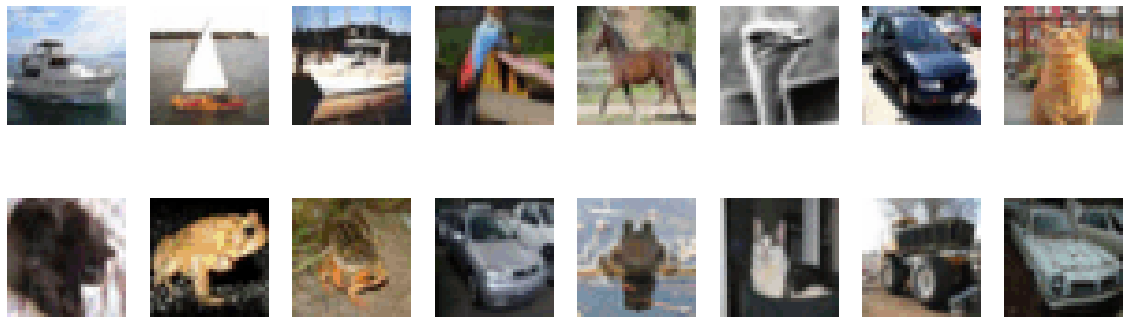

In [10]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = train_data[np.random.randint(0, len(train_data))]
    xpt = torch.from_numpy(np.array(x)).float().view(32*32, 3)
    ix = ((xpt[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1) # cluster assignments for each pixel
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[ix].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

The images above look relatively reasonable, so our 512-sized codebook is enough to reasonably re-represent RGB values. Ok cool. So now every image is just a 1024-long sequence of numbers between 0..511. Time to train a GPT.

In [11]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset, clusters, perm=None):
        self.pt_dataset = pt_dataset
        self.clusters = clusters
        self.perm = torch.arange(32*32) if perm is None else perm
        
        self.vocab_size = clusters.size(0)
        self.block_size = 32*32 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1, 3) # flatten out all pixels
        x = x[self.perm].float() # reshuffle pixels with any fixed permutation and -> float
        a = ((x[:, None, :] - self.clusters[None, :, :])**2).sum(-1).argmin(1) # cluster assignments
        return a[:-1], a[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_data, C)
test_dataset = ImageDataset(test_data, C)
train_dataset[0][0] # one example image flattened out into integers

tensor([449, 229, 229,  ..., 379,   0, 177])


For reference, **iGPT-S** from the paper is:
- batch size of 128 and trained for 1M terations
- Adam lr 0.003 with betas = (0.9, 0.95)
- learning rate is warmed up for one epoch, then decays to 0
- did not use weight decay or dropout
- `n_layer=24, n_head=8, n_embd=512`

We will do something similar but smaller

In [12]:

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=12, n_head=8, n_embd=256)
model = GPT(mconf)

In [13]:

"""
Note that Karpathy running on an 8-GPU V100 machine so each GPU has 32GB.
He use a batch of 16*8 in the original implementation. I brought this down to 8
so it could fit into Kaggle TPU.
If you don't have as many computational resources you have to bring down
the batch_size until the model fits into your memory, and then you may
also need to adjust the learning rate (e.g. decrease it a bit). Alternatively,
you can use an even smaller model up above, bringing down the number of layers,
number of heads, and the embedding size.
"""

tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 20 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=8, learning_rate=3e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='cifar10_model.pt',
                      num_workers=8)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()


  0%|          | 0/6250 [00:00<?, ?it/s]


epoch 1 iter 0: train loss 6.29280. lr 4.800000e-07:   0%|          | 0/6250 [00:29<?, ?it/s]


epoch 1 iter 0: train loss 6.29280. lr 4.800000e-07:   0%|          | 1/6250 [00:29<52:02:45, 29.98s/it]


epoch 1 iter 1: train loss 6.31060. lr 9.600000e-07:   0%|          | 1/6250 [00:55<52:02:45, 29.98s/it]


epoch 1 iter 1: train loss 6.31060. lr 9.600000e-07:   0%|          | 2/6250 [00:55<49:31:20, 28.53s/it]


epoch 1 iter 2: train loss 6.30733. lr 1.440000e-06:   0%|          | 2/6250 [01:17<49:31:20, 28.53s/it]


epoch 1 iter 2: train loss 6.30733. lr 1.440000e-06:   0%|          | 3/6250 [01:17<46:19:03, 26.69s/it]


epoch 1 iter 3: train loss 6.25031. lr 1.920000e-06:   0%|          | 3/6250 [01:40<46:19:03, 26.69s/it]


epoch 1 iter 3: train loss 6.25031. lr 1.920000e-06:   0%|          | 4/6250 [01:40<44:11:28, 25.47s/it]


epoch 1 iter 4: train loss 6.33509. lr 2.400000e-06:   0%|          | 4/6250 [02:03<44:11:28, 25.47s/it]


epoch 1 iter 4: train loss 6.33509. lr 2.400000e-06:   0%|          | 5/6250 [02:03<43:08:26, 24.87s/it]


epoch 1 iter 5: train loss 6.31169. lr 2.880000e-06:   0%|          | 5/6250 [02:25<43:08:26, 24.87s/it]


epoch 1 iter 5: train loss 6.31169. lr 2.880000e-06:   0%|          | 6/6250 [02:25<41:32:18, 23.95s/it]


epoch 1 iter 6: train loss 6.19094. lr 3.360000e-06:   0%|          | 6/6250 [02:46<41:32:18, 23.95s/it]


epoch 1 iter 6: train loss 6.19094. lr 3.360000e-06:   0%|          | 7/6250 [02:46<40:00:13, 23.07s/it]


epoch 1 iter 7: train loss 6.30672. lr 3.840000e-06:   0%|          | 7/6250 [03:08<40:00:13, 23.07s/it]


epoch 1 iter 7: train loss 6.30672. lr 3.840000e-06:   0%|          | 8/6250 [03:08<39:26:31, 22.75s/it]


epoch 1 iter 8: train loss 6.27023. lr 4.320000e-06:   0%|          | 8/6250 [03:29<39:26:31, 22.75s/it]


epoch 1 iter 8: train loss 6.27023. lr 4.320000e-06:   0%|          | 9/6250 [03:29<38:37:24, 22.28s/it]


epoch 1 iter 9: train loss 6.31565. lr 4.800000e-06:   0%|          | 9/6250 [03:51<38:37:24, 22.28s/it]


epoch 1 iter 9: train loss 6.31565. lr 4.800000e-06:   0%|          | 10/6250 [03:51<38:21:31, 22.13s/it]


epoch 1 iter 10: train loss 6.27451. lr 5.280000e-06:   0%|          | 10/6250 [04:14<38:21:31, 22.13s/it]


epoch 1 iter 10: train loss 6.27451. lr 5.280000e-06:   0%|          | 11/6250 [04:14<38:47:05, 22.38s/it]


epoch 1 iter 11: train loss 6.19173. lr 5.760000e-06:   0%|          | 11/6250 [04:36<38:47:05, 22.38s/it]


epoch 1 iter 11: train loss 6.19173. lr 5.760000e-06:   0%|          | 12/6250 [04:36<38:25:36, 22.18s/it]


epoch 1 iter 12: train loss 6.23338. lr 6.240000e-06:   0%|          | 12/6250 [04:59<38:25:36, 22.18s/it]


epoch 1 iter 12: train loss 6.23338. lr 6.240000e-06:   0%|          | 13/6250 [04:59<39:04:25, 22.55s/it]


epoch 1 iter 13: train loss 6.26474. lr 6.720000e-06:   0%|          | 13/6250 [05:21<39:04:25, 22.55s/it]


epoch 1 iter 13: train loss 6.26474. lr 6.720000e-06:   0%|          | 14/6250 [05:21<38:50:06, 22.42s/it]


epoch 1 iter 14: train loss 6.30889. lr 7.200000e-06:   0%|          | 14/6250 [05:42<38:50:06, 22.42s/it]


epoch 1 iter 14: train loss 6.30889. lr 7.200000e-06:   0%|          | 15/6250 [05:42<38:02:58, 21.97s/it]


epoch 1 iter 15: train loss 6.28060. lr 7.680000e-06:   0%|          | 15/6250 [06:03<38:02:58, 21.97s/it]


epoch 1 iter 15: train loss 6.28060. lr 7.680000e-06:   0%|          | 16/6250 [06:03<37:46:28, 21.81s/it]


epoch 1 iter 16: train loss 6.24395. lr 8.160000e-06:   0%|          | 16/6250 [06:25<37:46:28, 21.81s/it]


epoch 1 iter 16: train loss 6.24395. lr 8.160000e-06:   0%|          | 17/6250 [06:25<37:30:58, 21.67s/it]


epoch 1 iter 17: train loss 6.22388. lr 8.640000e-06:   0%|          | 17/6250 [06:46<37:30:58, 21.67s/it]


epoch 1 iter 17: train loss 6.22388. lr 8.640000e-06:   0%|          | 18/6250 [06:46<37:26:27, 21.63s/it]


epoch 1 iter 18: train loss 6.29463. lr 9.120000e-06:   0%|          | 18/6250 [07:08<37:26:27, 21.63s/it]


epoch 1 iter 18: train loss 6.29463. lr 9.120000e-06:   0%|          | 19/6250 [07:08<37:24:59, 21.62s/it]


epoch 1 iter 19: train loss 6.14259. lr 9.600000e-06:   0%|          | 19/6250 [07:29<37:24:59, 21.62s/it]


epoch 1 iter 19: train loss 6.14259. lr 9.600000e-06:   0%|          | 20/6250 [07:29<37:14:14, 21.52s/it]


epoch 1 iter 20: train loss 6.27257. lr 1.008000e-05:   0%|          | 20/6250 [07:50<37:14:14, 21.52s/it]


epoch 1 iter 20: train loss 6.27257. lr 1.008000e-05:   0%|          | 21/6250 [07:50<37:00:19, 21.39s/it]


epoch 1 iter 21: train loss 6.20481. lr 1.056000e-05:   0%|          | 21/6250 [08:12<37:00:19, 21.39s/it]


epoch 1 iter 21: train loss 6.20481. lr 1.056000e-05:   0%|          | 22/6250 [08:12<37:10:01, 21.48s/it]


epoch 1 iter 22: train loss 6.26640. lr 1.104000e-05:   0%|          | 22/6250 [08:33<37:10:01, 21.48s/it]


epoch 1 iter 22: train loss 6.26640. lr 1.104000e-05:   0%|          | 23/6250 [08:33<36:45:20, 21.25s/it]


epoch 1 iter 23: train loss 6.26989. lr 1.152000e-05:   0%|          | 23/6250 [08:54<36:45:20, 21.25s/it]


epoch 1 iter 23: train loss 6.26989. lr 1.152000e-05:   0%|          | 24/6250 [08:54<36:38:36, 21.19s/it]


epoch 1 iter 24: train loss 6.18657. lr 1.200000e-05:   0%|          | 24/6250 [09:16<36:38:36, 21.19s/it]


epoch 1 iter 24: train loss 6.18657. lr 1.200000e-05:   0%|          | 25/6250 [09:16<36:58:07, 21.38s/it]


epoch 1 iter 25: train loss 6.23137. lr 1.248000e-05:   0%|          | 25/6250 [09:36<36:58:07, 21.38s/it]


epoch 1 iter 25: train loss 6.23137. lr 1.248000e-05:   0%|          | 26/6250 [09:36<36:37:41, 21.19s/it]


epoch 1 iter 26: train loss 6.27650. lr 1.296000e-05:   0%|          | 26/6250 [09:57<36:37:41, 21.19s/it]


epoch 1 iter 26: train loss 6.27650. lr 1.296000e-05:   0%|          | 27/6250 [09:57<36:36:27, 21.18s/it]


epoch 1 iter 27: train loss 6.12286. lr 1.344000e-05:   0%|          | 27/6250 [10:20<36:36:27, 21.18s/it]


epoch 1 iter 27: train loss 6.12286. lr 1.344000e-05:   0%|          | 28/6250 [10:20<37:07:31, 21.48s/it]


epoch 1 iter 28: train loss 6.19112. lr 1.392000e-05:   0%|          | 28/6250 [10:41<37:07:31, 21.48s/it]


epoch 1 iter 28: train loss 6.19112. lr 1.392000e-05:   0%|          | 29/6250 [10:41<36:56:17, 21.38s/it]


epoch 1 iter 29: train loss 6.20045. lr 1.440000e-05:   0%|          | 29/6250 [11:02<36:56:17, 21.38s/it]


epoch 1 iter 29: train loss 6.20045. lr 1.440000e-05:   0%|          | 30/6250 [11:02<37:06:20, 21.48s/it]


epoch 1 iter 30: train loss 6.18595. lr 1.488000e-05:   0%|          | 30/6250 [11:24<37:06:20, 21.48s/it]


epoch 1 iter 30: train loss 6.18595. lr 1.488000e-05:   0%|          | 31/6250 [11:24<36:55:54, 21.38s/it]


epoch 1 iter 31: train loss 6.23331. lr 1.536000e-05:   0%|          | 31/6250 [11:45<36:55:54, 21.38s/it]


epoch 1 iter 31: train loss 6.23331. lr 1.536000e-05:   1%|          | 32/6250 [11:45<36:40:23, 21.23s/it]


epoch 1 iter 32: train loss 6.23513. lr 1.584000e-05:   1%|          | 32/6250 [12:06<36:40:23, 21.23s/it]


epoch 1 iter 32: train loss 6.23513. lr 1.584000e-05:   1%|          | 33/6250 [12:06<36:58:14, 21.41s/it]


epoch 1 iter 33: train loss 6.20896. lr 1.632000e-05:   1%|          | 33/6250 [12:28<36:58:14, 21.41s/it]


epoch 1 iter 33: train loss 6.20896. lr 1.632000e-05:   1%|          | 34/6250 [12:28<37:02:54, 21.46s/it]


epoch 1 iter 34: train loss 6.21309. lr 1.680000e-05:   1%|          | 34/6250 [12:49<37:02:54, 21.46s/it]


epoch 1 iter 34: train loss 6.21309. lr 1.680000e-05:   1%|          | 35/6250 [12:49<36:44:36, 21.28s/it]


epoch 1 iter 35: train loss 6.20308. lr 1.728000e-05:   1%|          | 35/6250 [13:10<36:44:36, 21.28s/it]


epoch 1 iter 35: train loss 6.20308. lr 1.728000e-05:   1%|          | 36/6250 [13:10<36:56:27, 21.40s/it]


epoch 1 iter 36: train loss 6.29224. lr 1.776000e-05:   1%|          | 36/6250 [13:32<36:56:27, 21.40s/it]


epoch 1 iter 36: train loss 6.29224. lr 1.776000e-05:   1%|          | 37/6250 [13:32<36:50:59, 21.35s/it]


epoch 1 iter 37: train loss 6.15712. lr 1.824000e-05:   1%|          | 37/6250 [13:53<36:50:59, 21.35s/it]


epoch 1 iter 37: train loss 6.15712. lr 1.824000e-05:   1%|          | 38/6250 [13:53<36:49:26, 21.34s/it]


epoch 1 iter 38: train loss 6.24766. lr 1.872000e-05:   1%|          | 38/6250 [14:15<36:49:26, 21.34s/it]


epoch 1 iter 38: train loss 6.24766. lr 1.872000e-05:   1%|          | 39/6250 [14:15<37:01:51, 21.46s/it]


epoch 1 iter 39: train loss 6.19453. lr 1.920000e-05:   1%|          | 39/6250 [14:36<37:01:51, 21.46s/it]


epoch 1 iter 39: train loss 6.19453. lr 1.920000e-05:   1%|          | 40/6250 [14:36<36:52:26, 21.38s/it]


epoch 1 iter 40: train loss 6.09186. lr 1.968000e-05:   1%|          | 40/6250 [14:57<36:52:26, 21.38s/it]


epoch 1 iter 40: train loss 6.09186. lr 1.968000e-05:   1%|          | 41/6250 [14:57<36:30:45, 21.17s/it]


epoch 1 iter 41: train loss 6.20617. lr 2.016000e-05:   1%|          | 41/6250 [15:19<36:30:45, 21.17s/it]


epoch 1 iter 41: train loss 6.20617. lr 2.016000e-05:   1%|          | 42/6250 [15:19<36:58:38, 21.44s/it]


epoch 1 iter 42: train loss 6.13151. lr 2.064000e-05:   1%|          | 42/6250 [15:40<36:58:38, 21.44s/it]


epoch 1 iter 42: train loss 6.13151. lr 2.064000e-05:   1%|          | 43/6250 [15:40<36:54:41, 21.41s/it]


epoch 1 iter 43: train loss 6.16796. lr 2.112000e-05:   1%|          | 43/6250 [16:02<36:54:41, 21.41s/it]


epoch 1 iter 43: train loss 6.16796. lr 2.112000e-05:   1%|          | 44/6250 [16:02<37:11:32, 21.57s/it]


epoch 1 iter 44: train loss 6.33122. lr 2.160000e-05:   1%|          | 44/6250 [16:24<37:11:32, 21.57s/it]


epoch 1 iter 44: train loss 6.33122. lr 2.160000e-05:   1%|          | 45/6250 [16:24<37:12:40, 21.59s/it]


epoch 1 iter 45: train loss 6.23562. lr 2.208000e-05:   1%|          | 45/6250 [16:45<37:12:40, 21.59s/it]


epoch 1 iter 45: train loss 6.23562. lr 2.208000e-05:   1%|          | 46/6250 [16:45<36:56:17, 21.43s/it]


epoch 1 iter 46: train loss 6.06347. lr 2.256000e-05:   1%|          | 46/6250 [17:08<36:56:17, 21.43s/it]


epoch 1 iter 46: train loss 6.06347. lr 2.256000e-05:   1%|          | 47/6250 [17:08<37:41:30, 21.87s/it]


epoch 1 iter 47: train loss 6.23523. lr 2.304000e-05:   1%|          | 47/6250 [17:29<37:41:30, 21.87s/it]


epoch 1 iter 47: train loss 6.23523. lr 2.304000e-05:   1%|          | 48/6250 [17:29<37:18:06, 21.65s/it]


epoch 1 iter 48: train loss 6.13406. lr 2.352000e-05:   1%|          | 48/6250 [17:50<37:18:06, 21.65s/it]


epoch 1 iter 48: train loss 6.13406. lr 2.352000e-05:   1%|          | 49/6250 [17:50<37:12:48, 21.60s/it]


epoch 1 iter 49: train loss 6.18942. lr 2.400000e-05:   1%|          | 49/6250 [18:12<37:12:48, 21.60s/it]


epoch 1 iter 49: train loss 6.18942. lr 2.400000e-05:   1%|          | 50/6250 [18:12<37:07:43, 21.56s/it]


epoch 1 iter 50: train loss 6.24431. lr 2.448000e-05:   1%|          | 50/6250 [18:33<37:07:43, 21.56s/it]


epoch 1 iter 50: train loss 6.24431. lr 2.448000e-05:   1%|          | 51/6250 [18:33<36:51:57, 21.41s/it]


epoch 1 iter 51: train loss 5.94540. lr 2.496000e-05:   1%|          | 51/6250 [18:54<36:51:57, 21.41s/it]


epoch 1 iter 51: train loss 5.94540. lr 2.496000e-05:   1%|          | 52/6250 [18:54<36:46:51, 21.36s/it]


epoch 1 iter 52: train loss 6.13434. lr 2.544000e-05:   1%|          | 52/6250 [19:15<36:46:51, 21.36s/it]


epoch 1 iter 52: train loss 6.13434. lr 2.544000e-05:   1%|          | 53/6250 [19:15<36:50:00, 21.40s/it]


epoch 1 iter 53: train loss 6.05104. lr 2.592000e-05:   1%|          | 53/6250 [19:36<36:50:00, 21.40s/it]


epoch 1 iter 53: train loss 6.05104. lr 2.592000e-05:   1%|          | 54/6250 [19:36<36:37:18, 21.28s/it]


epoch 1 iter 54: train loss 6.17633. lr 2.640000e-05:   1%|          | 54/6250 [19:58<36:37:18, 21.28s/it]


epoch 1 iter 54: train loss 6.17633. lr 2.640000e-05:   1%|          | 55/6250 [19:58<36:36:30, 21.27s/it]


epoch 1 iter 55: train loss 6.13064. lr 2.688000e-05:   1%|          | 55/6250 [20:19<36:36:30, 21.27s/it]


epoch 1 iter 55: train loss 6.13064. lr 2.688000e-05:   1%|          | 56/6250 [20:19<36:36:19, 21.28s/it]


epoch 1 iter 56: train loss 6.09470. lr 2.736000e-05:   1%|          | 56/6250 [20:40<36:36:19, 21.28s/it]


epoch 1 iter 56: train loss 6.09470. lr 2.736000e-05:   1%|          | 57/6250 [20:40<36:32:09, 21.24s/it]


epoch 1 iter 57: train loss 6.18662. lr 2.784000e-05:   1%|          | 57/6250 [21:02<36:32:09, 21.24s/it]


epoch 1 iter 57: train loss 6.18662. lr 2.784000e-05:   1%|          | 58/6250 [21:02<36:44:35, 21.36s/it]


epoch 1 iter 58: train loss 6.14048. lr 2.832000e-05:   1%|          | 58/6250 [21:23<36:44:35, 21.36s/it]


epoch 1 iter 58: train loss 6.14048. lr 2.832000e-05:   1%|          | 59/6250 [21:23<36:48:25, 21.40s/it]


epoch 1 iter 59: train loss 6.16428. lr 2.880000e-05:   1%|          | 59/6250 [21:45<36:48:25, 21.40s/it]


epoch 1 iter 59: train loss 6.16428. lr 2.880000e-05:   1%|          | 60/6250 [21:45<36:41:24, 21.34s/it]


epoch 1 iter 60: train loss 6.18027. lr 2.928000e-05:   1%|          | 60/6250 [22:06<36:41:24, 21.34s/it]


epoch 1 iter 60: train loss 6.18027. lr 2.928000e-05:   1%|          | 61/6250 [22:06<36:55:43, 21.48s/it]


epoch 1 iter 61: train loss 6.11975. lr 2.976000e-05:   1%|          | 61/6250 [22:27<36:55:43, 21.48s/it]


epoch 1 iter 61: train loss 6.11975. lr 2.976000e-05:   1%|          | 62/6250 [22:27<36:38:58, 21.32s/it]


epoch 1 iter 62: train loss 6.13694. lr 3.024000e-05:   1%|          | 62/6250 [22:49<36:38:58, 21.32s/it]


epoch 1 iter 62: train loss 6.13694. lr 3.024000e-05:   1%|          | 63/6250 [22:49<36:43:39, 21.37s/it]


epoch 1 iter 63: train loss 5.98684. lr 3.072000e-05:   1%|          | 63/6250 [23:11<36:43:39, 21.37s/it]


epoch 1 iter 63: train loss 5.98684. lr 3.072000e-05:   1%|          | 64/6250 [23:11<36:56:54, 21.50s/it]


epoch 1 iter 64: train loss 6.17745. lr 3.120000e-05:   1%|          | 64/6250 [23:31<36:56:54, 21.50s/it]


epoch 1 iter 64: train loss 6.17745. lr 3.120000e-05:   1%|          | 65/6250 [23:31<36:34:11, 21.29s/it]


epoch 1 iter 65: train loss 6.12363. lr 3.168000e-05:   1%|          | 65/6250 [23:53<36:34:11, 21.29s/it]


epoch 1 iter 65: train loss 6.12363. lr 3.168000e-05:   1%|          | 66/6250 [23:53<36:32:22, 21.27s/it]


epoch 1 iter 66: train loss 6.06047. lr 3.216000e-05:   1%|          | 66/6250 [24:15<36:32:22, 21.27s/it]


epoch 1 iter 66: train loss 6.06047. lr 3.216000e-05:   1%|          | 67/6250 [24:15<36:56:07, 21.51s/it]


epoch 1 iter 67: train loss 5.95987. lr 3.264000e-05:   1%|          | 67/6250 [24:35<36:56:07, 21.51s/it]


epoch 1 iter 67: train loss 5.95987. lr 3.264000e-05:   1%|          | 68/6250 [24:35<36:33:43, 21.29s/it]


epoch 1 iter 68: train loss 6.03712. lr 3.312000e-05:   1%|          | 68/6250 [24:57<36:33:43, 21.29s/it]


epoch 1 iter 68: train loss 6.03712. lr 3.312000e-05:   1%|          | 69/6250 [24:57<36:30:38, 21.26s/it]


epoch 1 iter 69: train loss 6.12989. lr 3.360000e-05:   1%|          | 69/6250 [25:18<36:30:38, 21.26s/it]


epoch 1 iter 69: train loss 6.12989. lr 3.360000e-05:   1%|          | 70/6250 [25:18<36:43:26, 21.39s/it]


epoch 1 iter 70: train loss 6.12571. lr 3.408000e-05:   1%|          | 70/6250 [25:39<36:43:26, 21.39s/it]


epoch 1 iter 70: train loss 6.12571. lr 3.408000e-05:   1%|          | 71/6250 [25:39<36:22:59, 21.20s/it]


epoch 1 iter 71: train loss 5.96498. lr 3.456000e-05:   1%|          | 71/6250 [26:01<36:22:59, 21.20s/it]


epoch 1 iter 71: train loss 5.96498. lr 3.456000e-05:   1%|          | 72/6250 [26:01<36:43:13, 21.40s/it]


epoch 1 iter 72: train loss 5.85589. lr 3.504000e-05:   1%|          | 72/6250 [26:23<36:43:13, 21.40s/it]


epoch 1 iter 72: train loss 5.85589. lr 3.504000e-05:   1%|          | 73/6250 [26:23<36:52:27, 21.49s/it]


epoch 1 iter 73: train loss 6.13946. lr 3.552000e-05:   1%|          | 73/6250 [26:44<36:52:27, 21.49s/it]


epoch 1 iter 73: train loss 6.13946. lr 3.552000e-05:   1%|          | 74/6250 [26:44<36:47:31, 21.45s/it]


epoch 1 iter 74: train loss 6.05950. lr 3.600000e-05:   1%|          | 74/6250 [27:06<36:47:31, 21.45s/it]


epoch 1 iter 74: train loss 6.05950. lr 3.600000e-05:   1%|          | 75/6250 [27:06<37:02:22, 21.59s/it]


epoch 1 iter 75: train loss 6.12531. lr 3.648000e-05:   1%|          | 75/6250 [27:27<37:02:22, 21.59s/it]


epoch 1 iter 75: train loss 6.12531. lr 3.648000e-05:   1%|          | 76/6250 [27:27<36:46:52, 21.45s/it]


epoch 1 iter 76: train loss 6.12034. lr 3.696000e-05:   1%|          | 76/6250 [27:48<36:46:52, 21.45s/it]


epoch 1 iter 76: train loss 6.12034. lr 3.696000e-05:   1%|          | 77/6250 [27:48<36:27:50, 21.27s/it]


epoch 1 iter 77: train loss 6.07100. lr 3.744000e-05:   1%|          | 77/6250 [28:10<36:27:50, 21.27s/it]


epoch 1 iter 77: train loss 6.07100. lr 3.744000e-05:   1%|          | 78/6250 [28:10<36:58:05, 21.56s/it]


epoch 1 iter 78: train loss 6.11631. lr 3.792000e-05:   1%|          | 78/6250 [28:31<36:58:05, 21.56s/it]


epoch 1 iter 78: train loss 6.11631. lr 3.792000e-05:   1%|▏         | 79/6250 [28:31<36:37:50, 21.37s/it]


epoch 1 iter 79: train loss 6.12321. lr 3.840000e-05:   1%|▏         | 79/6250 [28:53<36:37:50, 21.37s/it]


epoch 1 iter 79: train loss 6.12321. lr 3.840000e-05:   1%|▏         | 80/6250 [28:53<36:42:49, 21.42s/it]


epoch 1 iter 80: train loss 6.10412. lr 3.888000e-05:   1%|▏         | 80/6250 [29:14<36:42:49, 21.42s/it]


epoch 1 iter 80: train loss 6.10412. lr 3.888000e-05:   1%|▏         | 81/6250 [29:14<36:56:18, 21.56s/it]


epoch 1 iter 81: train loss 6.13081. lr 3.936000e-05:   1%|▏         | 81/6250 [29:35<36:56:18, 21.56s/it]


epoch 1 iter 81: train loss 6.13081. lr 3.936000e-05:   1%|▏         | 82/6250 [29:35<36:33:32, 21.34s/it]


epoch 1 iter 82: train loss 5.99502. lr 3.984000e-05:   1%|▏         | 82/6250 [29:57<36:33:32, 21.34s/it]


epoch 1 iter 82: train loss 5.99502. lr 3.984000e-05:   1%|▏         | 83/6250 [29:57<36:50:51, 21.51s/it]


epoch 1 iter 83: train loss 5.81713. lr 4.032000e-05:   1%|▏         | 83/6250 [30:19<36:50:51, 21.51s/it]


epoch 1 iter 83: train loss 5.81713. lr 4.032000e-05:   1%|▏         | 84/6250 [30:19<37:10:41, 21.71s/it]


epoch 1 iter 84: train loss 6.11558. lr 4.080000e-05:   1%|▏         | 84/6250 [30:40<37:10:41, 21.71s/it]


epoch 1 iter 84: train loss 6.11558. lr 4.080000e-05:   1%|▏         | 85/6250 [30:40<36:40:21, 21.41s/it]


epoch 1 iter 85: train loss 6.15724. lr 4.128000e-05:   1%|▏         | 85/6250 [31:02<36:40:21, 21.41s/it]


epoch 1 iter 85: train loss 6.15724. lr 4.128000e-05:   1%|▏         | 86/6250 [31:02<36:51:54, 21.53s/it]


epoch 1 iter 86: train loss 6.08232. lr 4.176000e-05:   1%|▏         | 86/6250 [31:24<36:51:54, 21.53s/it]


epoch 1 iter 86: train loss 6.08232. lr 4.176000e-05:   1%|▏         | 87/6250 [31:24<36:55:01, 21.56s/it]


epoch 1 iter 87: train loss 6.04171. lr 4.224000e-05:   1%|▏         | 87/6250 [31:45<36:55:01, 21.56s/it]


epoch 1 iter 87: train loss 6.04171. lr 4.224000e-05:   1%|▏         | 88/6250 [31:45<36:43:45, 21.46s/it]


epoch 1 iter 88: train loss 6.13275. lr 4.272000e-05:   1%|▏         | 88/6250 [32:09<36:43:45, 21.46s/it]


epoch 1 iter 88: train loss 6.13275. lr 4.272000e-05:   1%|▏         | 89/6250 [32:09<38:13:23, 22.33s/it]


epoch 1 iter 89: train loss 5.92351. lr 4.320000e-05:   1%|▏         | 89/6250 [32:30<38:13:23, 22.33s/it]


epoch 1 iter 89: train loss 5.92351. lr 4.320000e-05:   1%|▏         | 90/6250 [32:30<37:40:00, 22.01s/it]


epoch 1 iter 90: train loss 5.91756. lr 4.368000e-05:   1%|▏         | 90/6250 [32:52<37:40:00, 22.01s/it]


epoch 1 iter 90: train loss 5.91756. lr 4.368000e-05:   1%|▏         | 91/6250 [32:52<37:14:02, 21.76s/it]


epoch 1 iter 91: train loss 6.07095. lr 4.416000e-05:   1%|▏         | 91/6250 [33:13<37:14:02, 21.76s/it]


epoch 1 iter 91: train loss 6.07095. lr 4.416000e-05:   1%|▏         | 92/6250 [33:13<37:16:26, 21.79s/it]


epoch 1 iter 92: train loss 6.04552. lr 4.464000e-05:   1%|▏         | 92/6250 [33:35<37:16:26, 21.79s/it]


epoch 1 iter 92: train loss 6.04552. lr 4.464000e-05:   1%|▏         | 93/6250 [33:35<37:02:37, 21.66s/it]


epoch 1 iter 93: train loss 5.93960. lr 4.512000e-05:   1%|▏         | 93/6250 [33:56<37:02:37, 21.66s/it]


epoch 1 iter 93: train loss 5.93960. lr 4.512000e-05:   2%|▏         | 94/6250 [33:56<36:50:22, 21.54s/it]


epoch 1 iter 94: train loss 6.00581. lr 4.560000e-05:   2%|▏         | 94/6250 [34:18<36:50:22, 21.54s/it]


epoch 1 iter 94: train loss 6.00581. lr 4.560000e-05:   2%|▏         | 95/6250 [34:18<36:55:38, 21.60s/it]


epoch 1 iter 95: train loss 6.00509. lr 4.608000e-05:   2%|▏         | 95/6250 [34:39<36:55:38, 21.60s/it]


epoch 1 iter 95: train loss 6.00509. lr 4.608000e-05:   2%|▏         | 96/6250 [34:39<36:34:17, 21.39s/it]


epoch 1 iter 96: train loss 6.05755. lr 4.656000e-05:   2%|▏         | 96/6250 [35:00<36:34:17, 21.39s/it]


epoch 1 iter 96: train loss 6.05755. lr 4.656000e-05:   2%|▏         | 97/6250 [35:00<36:36:48, 21.42s/it]


epoch 1 iter 97: train loss 5.98353. lr 4.704000e-05:   2%|▏         | 97/6250 [35:22<36:36:48, 21.42s/it]


epoch 1 iter 97: train loss 5.98353. lr 4.704000e-05:   2%|▏         | 98/6250 [35:22<36:41:45, 21.47s/it]


epoch 1 iter 98: train loss 5.99075. lr 4.752000e-05:   2%|▏         | 98/6250 [35:43<36:41:45, 21.47s/it]


epoch 1 iter 98: train loss 5.99075. lr 4.752000e-05:   2%|▏         | 99/6250 [35:43<36:22:16, 21.29s/it]


epoch 1 iter 99: train loss 6.02323. lr 4.800000e-05:   2%|▏         | 99/6250 [36:04<36:22:16, 21.29s/it]


epoch 1 iter 99: train loss 6.02323. lr 4.800000e-05:   2%|▏         | 100/6250 [36:04<36:28:29, 21.35s/it]


epoch 1 iter 100: train loss 5.99977. lr 4.848000e-05:   2%|▏         | 100/6250 [36:25<36:28:29, 21.35s/it]


epoch 1 iter 100: train loss 5.99977. lr 4.848000e-05:   2%|▏         | 101/6250 [36:25<36:16:34, 21.24s/it]


epoch 1 iter 101: train loss 5.89094. lr 4.896000e-05:   2%|▏         | 101/6250 [36:46<36:16:34, 21.24s/it]


epoch 1 iter 101: train loss 5.89094. lr 4.896000e-05:   2%|▏         | 102/6250 [36:46<36:17:10, 21.25s/it]


epoch 1 iter 102: train loss 6.08436. lr 4.944000e-05:   2%|▏         | 102/6250 [37:08<36:17:10, 21.25s/it]


epoch 1 iter 102: train loss 6.08436. lr 4.944000e-05:   2%|▏         | 103/6250 [37:08<36:32:52, 21.40s/it]


epoch 1 iter 103: train loss 6.13117. lr 4.992000e-05:   2%|▏         | 103/6250 [37:30<36:32:52, 21.40s/it]


epoch 1 iter 103: train loss 6.13117. lr 4.992000e-05:   2%|▏         | 104/6250 [37:30<36:36:08, 21.44s/it]


epoch 1 iter 104: train loss 5.84851. lr 5.040000e-05:   2%|▏         | 104/6250 [37:51<36:36:08, 21.44s/it]


epoch 1 iter 104: train loss 5.84851. lr 5.040000e-05:   2%|▏         | 105/6250 [37:51<36:29:14, 21.38s/it]


epoch 1 iter 105: train loss 6.08630. lr 5.088000e-05:   2%|▏         | 105/6250 [38:13<36:29:14, 21.38s/it]


epoch 1 iter 105: train loss 6.08630. lr 5.088000e-05:   2%|▏         | 106/6250 [38:13<36:45:34, 21.54s/it]


epoch 1 iter 106: train loss 5.93463. lr 5.136000e-05:   2%|▏         | 106/6250 [38:34<36:45:34, 21.54s/it]


epoch 1 iter 106: train loss 5.93463. lr 5.136000e-05:   2%|▏         | 107/6250 [38:34<36:32:01, 21.41s/it]


epoch 1 iter 107: train loss 5.90629. lr 5.184000e-05:   2%|▏         | 107/6250 [38:55<36:32:01, 21.41s/it]


epoch 1 iter 107: train loss 5.90629. lr 5.184000e-05:   2%|▏         | 108/6250 [38:55<36:26:43, 21.36s/it]


epoch 1 iter 108: train loss 6.04641. lr 5.232000e-05:   2%|▏         | 108/6250 [39:17<36:26:43, 21.36s/it]


epoch 1 iter 108: train loss 6.04641. lr 5.232000e-05:   2%|▏         | 109/6250 [39:17<36:34:23, 21.44s/it]


epoch 1 iter 109: train loss 6.11483. lr 5.280000e-05:   2%|▏         | 109/6250 [39:38<36:34:23, 21.44s/it]


epoch 1 iter 109: train loss 6.11483. lr 5.280000e-05:   2%|▏         | 110/6250 [39:38<36:30:35, 21.41s/it]


epoch 1 iter 110: train loss 6.00940. lr 5.328000e-05:   2%|▏         | 110/6250 [40:00<36:30:35, 21.41s/it]


epoch 1 iter 110: train loss 6.00940. lr 5.328000e-05:   2%|▏         | 111/6250 [40:00<36:34:01, 21.44s/it]


epoch 1 iter 111: train loss 5.81382. lr 5.376000e-05:   2%|▏         | 111/6250 [40:21<36:34:01, 21.44s/it]


epoch 1 iter 111: train loss 5.81382. lr 5.376000e-05:   2%|▏         | 112/6250 [40:21<36:30:21, 21.41s/it]


epoch 1 iter 112: train loss 5.78856. lr 5.424000e-05:   2%|▏         | 112/6250 [40:42<36:30:21, 21.41s/it]


epoch 1 iter 112: train loss 5.78856. lr 5.424000e-05:   2%|▏         | 113/6250 [40:42<36:16:20, 21.28s/it]


epoch 1 iter 113: train loss 5.89809. lr 5.472000e-05:   2%|▏         | 113/6250 [41:04<36:16:20, 21.28s/it]


epoch 1 iter 113: train loss 5.89809. lr 5.472000e-05:   2%|▏         | 114/6250 [41:04<36:32:38, 21.44s/it]


epoch 1 iter 114: train loss 5.93093. lr 5.520000e-05:   2%|▏         | 114/6250 [41:25<36:32:38, 21.44s/it]


epoch 1 iter 114: train loss 5.93093. lr 5.520000e-05:   2%|▏         | 115/6250 [41:25<36:18:02, 21.30s/it]


epoch 1 iter 115: train loss 5.99861. lr 5.568000e-05:   2%|▏         | 115/6250 [41:46<36:18:02, 21.30s/it]


epoch 1 iter 115: train loss 5.99861. lr 5.568000e-05:   2%|▏         | 116/6250 [41:46<36:16:58, 21.29s/it]


epoch 1 iter 116: train loss 6.03823. lr 5.616000e-05:   2%|▏         | 116/6250 [42:08<36:16:58, 21.29s/it]


epoch 1 iter 116: train loss 6.03823. lr 5.616000e-05:   2%|▏         | 117/6250 [42:08<36:27:44, 21.40s/it]


epoch 1 iter 117: train loss 6.02326. lr 5.664000e-05:   2%|▏         | 117/6250 [42:29<36:27:44, 21.40s/it]


epoch 1 iter 117: train loss 6.02326. lr 5.664000e-05:   2%|▏         | 118/6250 [42:29<36:12:50, 21.26s/it]


epoch 1 iter 118: train loss 6.02982. lr 5.712000e-05:   2%|▏         | 118/6250 [42:50<36:12:50, 21.26s/it]


epoch 1 iter 118: train loss 6.02982. lr 5.712000e-05:   2%|▏         | 119/6250 [42:50<36:20:46, 21.34s/it]


epoch 1 iter 119: train loss 5.89795. lr 5.760000e-05:   2%|▏         | 119/6250 [43:12<36:20:46, 21.34s/it]


epoch 1 iter 119: train loss 5.89795. lr 5.760000e-05:   2%|▏         | 120/6250 [43:12<36:29:14, 21.43s/it]


epoch 1 iter 120: train loss 5.98390. lr 5.808000e-05:   2%|▏         | 120/6250 [43:33<36:29:14, 21.43s/it]


epoch 1 iter 120: train loss 5.98390. lr 5.808000e-05:   2%|▏         | 121/6250 [43:33<36:15:30, 21.30s/it]


epoch 1 iter 121: train loss 5.89780. lr 5.856000e-05:   2%|▏         | 121/6250 [43:54<36:15:30, 21.30s/it]


epoch 1 iter 121: train loss 5.89780. lr 5.856000e-05:   2%|▏         | 122/6250 [43:54<36:13:27, 21.28s/it]


epoch 1 iter 122: train loss 5.97042. lr 5.904000e-05:   2%|▏         | 122/6250 [44:16<36:13:27, 21.28s/it]


epoch 1 iter 122: train loss 5.97042. lr 5.904000e-05:   2%|▏         | 123/6250 [44:16<36:28:37, 21.43s/it]


epoch 1 iter 123: train loss 6.07877. lr 5.952000e-05:   2%|▏         | 123/6250 [44:37<36:28:37, 21.43s/it]


epoch 1 iter 123: train loss 6.07877. lr 5.952000e-05:   2%|▏         | 124/6250 [44:37<36:08:04, 21.23s/it]


epoch 1 iter 124: train loss 5.98111. lr 6.000000e-05:   2%|▏         | 124/6250 [44:58<36:08:04, 21.23s/it]


epoch 1 iter 124: train loss 5.98111. lr 6.000000e-05:   2%|▏         | 125/6250 [44:58<36:13:32, 21.29s/it]


epoch 1 iter 125: train loss 5.93770. lr 6.048000e-05:   2%|▏         | 125/6250 [45:20<36:13:32, 21.29s/it]


epoch 1 iter 125: train loss 5.93770. lr 6.048000e-05:   2%|▏         | 126/6250 [45:20<36:23:29, 21.39s/it]


epoch 1 iter 126: train loss 5.96580. lr 6.096000e-05:   2%|▏         | 126/6250 [45:40<36:23:29, 21.39s/it]


epoch 1 iter 126: train loss 5.96580. lr 6.096000e-05:   2%|▏         | 127/6250 [45:40<36:03:56, 21.20s/it]


epoch 1 iter 127: train loss 5.70673. lr 6.144000e-05:   2%|▏         | 127/6250 [46:02<36:03:56, 21.20s/it]


epoch 1 iter 127: train loss 5.70673. lr 6.144000e-05:   2%|▏         | 128/6250 [46:02<36:15:45, 21.32s/it]


epoch 1 iter 128: train loss 5.94960. lr 6.192000e-05:   2%|▏         | 128/6250 [46:24<36:15:45, 21.32s/it]


epoch 1 iter 128: train loss 5.94960. lr 6.192000e-05:   2%|▏         | 129/6250 [46:24<36:24:02, 21.41s/it]


epoch 1 iter 129: train loss 5.95841. lr 6.240000e-05:   2%|▏         | 129/6250 [46:44<36:24:02, 21.41s/it]


epoch 1 iter 129: train loss 5.95841. lr 6.240000e-05:   2%|▏         | 130/6250 [46:44<36:02:49, 21.20s/it]


epoch 1 iter 130: train loss 5.98333. lr 6.288000e-05:   2%|▏         | 130/6250 [47:06<36:02:49, 21.20s/it]


epoch 1 iter 130: train loss 5.98333. lr 6.288000e-05:   2%|▏         | 131/6250 [47:06<36:21:15, 21.39s/it]


epoch 1 iter 131: train loss 6.06970. lr 6.336000e-05:   2%|▏         | 131/6250 [47:28<36:21:15, 21.39s/it]


epoch 1 iter 131: train loss 6.06970. lr 6.336000e-05:   2%|▏         | 132/6250 [47:28<36:30:36, 21.48s/it]


epoch 1 iter 132: train loss 5.92709. lr 6.384000e-05:   2%|▏         | 132/6250 [47:50<36:30:36, 21.48s/it]


epoch 1 iter 132: train loss 5.92709. lr 6.384000e-05:   2%|▏         | 133/6250 [47:50<36:52:16, 21.70s/it]


epoch 1 iter 133: train loss 5.95664. lr 6.432000e-05:   2%|▏         | 133/6250 [48:13<36:52:16, 21.70s/it]


epoch 1 iter 133: train loss 5.95664. lr 6.432000e-05:   2%|▏         | 134/6250 [48:13<37:17:57, 21.96s/it]


epoch 1 iter 134: train loss 5.96980. lr 6.480000e-05:   2%|▏         | 134/6250 [48:34<37:17:57, 21.96s/it]


epoch 1 iter 134: train loss 5.96980. lr 6.480000e-05:   2%|▏         | 135/6250 [48:34<37:00:06, 21.78s/it]


epoch 1 iter 135: train loss 5.37488. lr 6.528000e-05:   2%|▏         | 135/6250 [48:55<37:00:06, 21.78s/it]


epoch 1 iter 135: train loss 5.37488. lr 6.528000e-05:   2%|▏         | 136/6250 [48:55<36:38:12, 21.57s/it]


epoch 1 iter 136: train loss 5.90600. lr 6.576000e-05:   2%|▏         | 136/6250 [49:17<36:38:12, 21.57s/it]


epoch 1 iter 136: train loss 5.90600. lr 6.576000e-05:   2%|▏         | 137/6250 [49:17<36:47:46, 21.67s/it]


epoch 1 iter 137: train loss 5.70949. lr 6.624000e-05:   2%|▏         | 137/6250 [49:38<36:47:46, 21.67s/it]


epoch 1 iter 137: train loss 5.70949. lr 6.624000e-05:   2%|▏         | 138/6250 [49:38<36:34:51, 21.55s/it]


epoch 1 iter 138: train loss 5.97829. lr 6.672000e-05:   2%|▏         | 138/6250 [49:59<36:34:51, 21.55s/it]


epoch 1 iter 138: train loss 5.97829. lr 6.672000e-05:   2%|▏         | 139/6250 [49:59<36:23:34, 21.44s/it]


epoch 1 iter 139: train loss 6.04714. lr 6.720000e-05:   2%|▏         | 139/6250 [50:21<36:23:34, 21.44s/it]


epoch 1 iter 139: train loss 6.04714. lr 6.720000e-05:   2%|▏         | 140/6250 [50:21<36:24:13, 21.45s/it]


epoch 1 iter 140: train loss 5.97403. lr 6.768000e-05:   2%|▏         | 140/6250 [50:42<36:24:13, 21.45s/it]


epoch 1 iter 140: train loss 5.97403. lr 6.768000e-05:   2%|▏         | 141/6250 [50:42<36:11:55, 21.33s/it]


epoch 1 iter 141: train loss 5.79565. lr 6.816000e-05:   2%|▏         | 141/6250 [51:03<36:11:55, 21.33s/it]


epoch 1 iter 141: train loss 5.79565. lr 6.816000e-05:   2%|▏         | 142/6250 [51:03<36:17:22, 21.39s/it]


epoch 1 iter 142: train loss 5.66181. lr 6.864000e-05:   2%|▏         | 142/6250 [51:25<36:17:22, 21.39s/it]


epoch 1 iter 142: train loss 5.66181. lr 6.864000e-05:   2%|▏         | 143/6250 [51:25<36:13:29, 21.35s/it]


epoch 1 iter 143: train loss 5.42026. lr 6.912000e-05:   2%|▏         | 143/6250 [51:46<36:13:29, 21.35s/it]


epoch 1 iter 143: train loss 5.42026. lr 6.912000e-05:   2%|▏         | 144/6250 [51:46<36:07:05, 21.29s/it]


epoch 1 iter 144: train loss 5.92327. lr 6.960000e-05:   2%|▏         | 144/6250 [52:08<36:07:05, 21.29s/it]


epoch 1 iter 144: train loss 5.92327. lr 6.960000e-05:   2%|▏         | 145/6250 [52:08<36:18:10, 21.41s/it]


epoch 1 iter 145: train loss 5.94104. lr 7.008000e-05:   2%|▏         | 145/6250 [52:29<36:18:10, 21.41s/it]


epoch 1 iter 145: train loss 5.94104. lr 7.008000e-05:   2%|▏         | 146/6250 [52:29<36:08:22, 21.31s/it]


epoch 1 iter 146: train loss 5.92840. lr 7.056000e-05:   2%|▏         | 146/6250 [52:50<36:08:22, 21.31s/it]


epoch 1 iter 146: train loss 5.92840. lr 7.056000e-05:   2%|▏         | 147/6250 [52:50<36:02:47, 21.26s/it]


epoch 1 iter 147: train loss 5.93262. lr 7.104000e-05:   2%|▏         | 147/6250 [53:11<36:02:47, 21.26s/it]


epoch 1 iter 147: train loss 5.93262. lr 7.104000e-05:   2%|▏         | 148/6250 [53:11<36:13:01, 21.37s/it]


epoch 1 iter 148: train loss 5.92134. lr 7.152000e-05:   2%|▏         | 148/6250 [53:32<36:13:01, 21.37s/it]


epoch 1 iter 148: train loss 5.92134. lr 7.152000e-05:   2%|▏         | 149/6250 [53:32<35:59:42, 21.24s/it]


epoch 1 iter 149: train loss 5.83450. lr 7.200000e-05:   2%|▏         | 149/6250 [53:53<35:59:42, 21.24s/it]


epoch 1 iter 149: train loss 5.83450. lr 7.200000e-05:   2%|▏         | 150/6250 [53:53<35:56:15, 21.21s/it]


epoch 1 iter 150: train loss 5.93053. lr 7.248000e-05:   2%|▏         | 150/6250 [54:15<35:56:15, 21.21s/it]


epoch 1 iter 150: train loss 5.93053. lr 7.248000e-05:   2%|▏         | 151/6250 [54:15<36:05:40, 21.31s/it]


epoch 1 iter 151: train loss 5.80197. lr 7.296000e-05:   2%|▏         | 151/6250 [54:36<36:05:40, 21.31s/it]


epoch 1 iter 151: train loss 5.80197. lr 7.296000e-05:   2%|▏         | 152/6250 [54:36<35:59:34, 21.25s/it]


epoch 1 iter 152: train loss 5.96071. lr 7.344000e-05:   2%|▏         | 152/6250 [54:57<35:59:34, 21.25s/it]


epoch 1 iter 152: train loss 5.96071. lr 7.344000e-05:   2%|▏         | 153/6250 [54:57<36:02:02, 21.28s/it]


epoch 1 iter 153: train loss 5.99200. lr 7.392000e-05:   2%|▏         | 153/6250 [55:19<36:02:02, 21.28s/it]


epoch 1 iter 153: train loss 5.99200. lr 7.392000e-05:   2%|▏         | 154/6250 [55:19<36:05:17, 21.31s/it]


epoch 1 iter 154: train loss 5.94181. lr 7.440000e-05:   2%|▏         | 154/6250 [55:40<36:05:17, 21.31s/it]


epoch 1 iter 154: train loss 5.94181. lr 7.440000e-05:   2%|▏         | 155/6250 [55:40<35:57:18, 21.24s/it]


epoch 1 iter 155: train loss 5.90996. lr 7.488000e-05:   2%|▏         | 155/6250 [56:01<35:57:18, 21.24s/it]


epoch 1 iter 155: train loss 5.90996. lr 7.488000e-05:   2%|▏         | 156/6250 [56:01<36:01:39, 21.28s/it]


epoch 1 iter 156: train loss 5.73647. lr 7.536000e-05:   2%|▏         | 156/6250 [56:22<36:01:39, 21.28s/it]


epoch 1 iter 156: train loss 5.73647. lr 7.536000e-05:   3%|▎         | 157/6250 [56:22<35:57:04, 21.24s/it]


epoch 1 iter 157: train loss 5.72989. lr 7.584000e-05:   3%|▎         | 157/6250 [56:44<35:57:04, 21.24s/it]


epoch 1 iter 157: train loss 5.72989. lr 7.584000e-05:   3%|▎         | 158/6250 [56:44<35:51:35, 21.19s/it]


epoch 1 iter 158: train loss 5.74061. lr 7.632000e-05:   3%|▎         | 158/6250 [57:05<35:51:35, 21.19s/it]


epoch 1 iter 158: train loss 5.74061. lr 7.632000e-05:   3%|▎         | 159/6250 [57:05<36:07:33, 21.35s/it]


epoch 1 iter 159: train loss 5.94462. lr 7.680000e-05:   3%|▎         | 159/6250 [57:26<36:07:33, 21.35s/it]


epoch 1 iter 159: train loss 5.94462. lr 7.680000e-05:   3%|▎         | 160/6250 [57:26<35:52:37, 21.21s/it]


epoch 1 iter 160: train loss 5.78312. lr 7.728000e-05:   3%|▎         | 160/6250 [57:47<35:52:37, 21.21s/it]


epoch 1 iter 160: train loss 5.78312. lr 7.728000e-05:   3%|▎         | 161/6250 [57:47<35:47:15, 21.16s/it]


epoch 1 iter 161: train loss 5.72471. lr 7.776000e-05:   3%|▎         | 161/6250 [58:09<35:47:15, 21.16s/it]


epoch 1 iter 161: train loss 5.72471. lr 7.776000e-05:   3%|▎         | 162/6250 [58:09<36:02:38, 21.31s/it]


epoch 1 iter 162: train loss 5.89827. lr 7.824000e-05:   3%|▎         | 162/6250 [58:30<36:02:38, 21.31s/it]


epoch 1 iter 162: train loss 5.89827. lr 7.824000e-05:   3%|▎         | 163/6250 [58:30<36:03:07, 21.32s/it]


epoch 1 iter 163: train loss 5.87597. lr 7.872000e-05:   3%|▎         | 163/6250 [58:52<36:03:07, 21.32s/it]


epoch 1 iter 163: train loss 5.87597. lr 7.872000e-05:   3%|▎         | 164/6250 [58:52<36:04:33, 21.34s/it]


epoch 1 iter 164: train loss 5.94685. lr 7.920000e-05:   3%|▎         | 164/6250 [59:13<36:04:33, 21.34s/it]


epoch 1 iter 164: train loss 5.94685. lr 7.920000e-05:   3%|▎         | 165/6250 [59:13<36:13:55, 21.44s/it]


epoch 1 iter 165: train loss 5.78813. lr 7.968000e-05:   3%|▎         | 165/6250 [59:34<36:13:55, 21.44s/it]


epoch 1 iter 165: train loss 5.78813. lr 7.968000e-05:   3%|▎         | 166/6250 [59:34<35:59:13, 21.29s/it]


epoch 1 iter 166: train loss 5.67571. lr 8.016000e-05:   3%|▎         | 166/6250 [59:55<35:59:13, 21.29s/it]


epoch 1 iter 166: train loss 5.67571. lr 8.016000e-05:   3%|▎         | 167/6250 [59:55<35:48:41, 21.19s/it]


epoch 1 iter 167: train loss 5.91040. lr 8.064000e-05:   3%|▎         | 167/6250 [1:00:17<35:48:41, 21.19s/it]


epoch 1 iter 167: train loss 5.91040. lr 8.064000e-05:   3%|▎         | 168/6250 [1:00:17<36:05:50, 21.37s/it]


epoch 1 iter 168: train loss 5.63121. lr 8.112000e-05:   3%|▎         | 168/6250 [1:00:38<36:05:50, 21.37s/it]


epoch 1 iter 168: train loss 5.63121. lr 8.112000e-05:   3%|▎         | 169/6250 [1:00:38<35:43:07, 21.15s/it]


epoch 1 iter 169: train loss 5.59936. lr 8.160000e-05:   3%|▎         | 169/6250 [1:00:59<35:43:07, 21.15s/it]


epoch 1 iter 169: train loss 5.59936. lr 8.160000e-05:   3%|▎         | 170/6250 [1:00:59<35:44:42, 21.16s/it]


epoch 1 iter 170: train loss 5.44404. lr 8.208000e-05:   3%|▎         | 170/6250 [1:01:20<35:44:42, 21.16s/it]


epoch 1 iter 170: train loss 5.44404. lr 8.208000e-05:   3%|▎         | 171/6250 [1:01:20<35:53:25, 21.25s/it]


epoch 1 iter 171: train loss 5.69501. lr 8.256000e-05:   3%|▎         | 171/6250 [1:01:41<35:53:25, 21.25s/it]


epoch 1 iter 171: train loss 5.69501. lr 8.256000e-05:   3%|▎         | 172/6250 [1:01:41<35:38:01, 21.11s/it]


epoch 1 iter 172: train loss 5.38518. lr 8.304000e-05:   3%|▎         | 172/6250 [1:02:02<35:38:01, 21.11s/it]


epoch 1 iter 172: train loss 5.38518. lr 8.304000e-05:   3%|▎         | 173/6250 [1:02:02<35:49:18, 21.22s/it]


epoch 1 iter 173: train loss 5.74989. lr 8.352000e-05:   3%|▎         | 173/6250 [1:02:24<35:49:18, 21.22s/it]


epoch 1 iter 173: train loss 5.74989. lr 8.352000e-05:   3%|▎         | 174/6250 [1:02:24<35:50:39, 21.24s/it]


epoch 1 iter 174: train loss 5.72783. lr 8.400000e-05:   3%|▎         | 174/6250 [1:02:45<35:50:39, 21.24s/it]


epoch 1 iter 174: train loss 5.72783. lr 8.400000e-05:   3%|▎         | 175/6250 [1:02:45<35:49:21, 21.23s/it]


epoch 1 iter 175: train loss 5.77122. lr 8.448000e-05:   3%|▎         | 175/6250 [1:03:10<35:49:21, 21.23s/it]


epoch 1 iter 175: train loss 5.77122. lr 8.448000e-05:   3%|▎         | 176/6250 [1:03:10<37:52:01, 22.44s/it]


epoch 1 iter 176: train loss 5.48469. lr 8.496000e-05:   3%|▎         | 176/6250 [1:03:32<37:52:01, 22.44s/it]


epoch 1 iter 176: train loss 5.48469. lr 8.496000e-05:   3%|▎         | 177/6250 [1:03:32<37:23:34, 22.17s/it]


epoch 1 iter 177: train loss 5.72931. lr 8.544000e-05:   3%|▎         | 177/6250 [1:03:54<37:23:34, 22.17s/it]


epoch 1 iter 177: train loss 5.72931. lr 8.544000e-05:   3%|▎         | 178/6250 [1:03:54<37:14:12, 22.08s/it]


epoch 1 iter 178: train loss 5.75683. lr 8.592000e-05:   3%|▎         | 178/6250 [1:04:16<37:14:12, 22.08s/it]


epoch 1 iter 178: train loss 5.75683. lr 8.592000e-05:   3%|▎         | 179/6250 [1:04:16<37:08:45, 22.03s/it]


epoch 1 iter 179: train loss 5.85431. lr 8.640000e-05:   3%|▎         | 179/6250 [1:04:37<37:08:45, 22.03s/it]


epoch 1 iter 179: train loss 5.85431. lr 8.640000e-05:   3%|▎         | 180/6250 [1:04:37<36:38:36, 21.73s/it]


epoch 1 iter 180: train loss 5.81868. lr 8.688000e-05:   3%|▎         | 180/6250 [1:04:58<36:38:36, 21.73s/it]


epoch 1 iter 180: train loss 5.81868. lr 8.688000e-05:   3%|▎         | 181/6250 [1:04:58<36:20:24, 21.56s/it]


epoch 1 iter 181: train loss 5.53726. lr 8.736000e-05:   3%|▎         | 181/6250 [1:05:19<36:20:24, 21.56s/it]


epoch 1 iter 181: train loss 5.53726. lr 8.736000e-05:   3%|▎         | 182/6250 [1:05:19<36:21:48, 21.57s/it]


epoch 1 iter 182: train loss 5.70120. lr 8.784000e-05:   3%|▎         | 182/6250 [1:05:40<36:21:48, 21.57s/it]


epoch 1 iter 182: train loss 5.70120. lr 8.784000e-05:   3%|▎         | 183/6250 [1:05:40<36:07:49, 21.44s/it]


epoch 1 iter 183: train loss 5.50479. lr 8.832000e-05:   3%|▎         | 183/6250 [1:06:02<36:07:49, 21.44s/it]


epoch 1 iter 183: train loss 5.50479. lr 8.832000e-05:   3%|▎         | 184/6250 [1:06:02<35:56:10, 21.33s/it]


epoch 1 iter 184: train loss 5.68819. lr 8.880000e-05:   3%|▎         | 184/6250 [1:06:23<35:56:10, 21.33s/it]


epoch 1 iter 184: train loss 5.68819. lr 8.880000e-05:   3%|▎         | 185/6250 [1:06:23<35:50:35, 21.28s/it]


epoch 1 iter 185: train loss 5.50201. lr 8.928000e-05:   3%|▎         | 185/6250 [1:06:44<35:50:35, 21.28s/it]


epoch 1 iter 185: train loss 5.50201. lr 8.928000e-05:   3%|▎         | 186/6250 [1:06:44<35:41:36, 21.19s/it]


epoch 1 iter 186: train loss 5.85012. lr 8.976000e-05:   3%|▎         | 186/6250 [1:07:05<35:41:36, 21.19s/it]


epoch 1 iter 186: train loss 5.85012. lr 8.976000e-05:   3%|▎         | 187/6250 [1:07:05<35:48:48, 21.26s/it]


epoch 1 iter 187: train loss 5.45349. lr 9.024000e-05:   3%|▎         | 187/6250 [1:07:26<35:48:48, 21.26s/it]


epoch 1 iter 187: train loss 5.45349. lr 9.024000e-05:   3%|▎         | 188/6250 [1:07:26<35:41:39, 21.20s/it]


epoch 1 iter 188: train loss 5.71149. lr 9.072000e-05:   3%|▎         | 188/6250 [1:07:47<35:41:39, 21.20s/it]


epoch 1 iter 188: train loss 5.71149. lr 9.072000e-05:   3%|▎         | 189/6250 [1:07:47<35:36:45, 21.15s/it]


epoch 1 iter 189: train loss 5.70449. lr 9.120000e-05:   3%|▎         | 189/6250 [1:08:09<35:36:45, 21.15s/it]


epoch 1 iter 189: train loss 5.70449. lr 9.120000e-05:   3%|▎         | 190/6250 [1:08:09<35:47:50, 21.27s/it]


epoch 1 iter 190: train loss 5.68861. lr 9.168000e-05:   3%|▎         | 190/6250 [1:08:30<35:47:50, 21.27s/it]


epoch 1 iter 190: train loss 5.68861. lr 9.168000e-05:   3%|▎         | 191/6250 [1:08:30<35:37:39, 21.17s/it]


epoch 1 iter 191: train loss 5.70576. lr 9.216000e-05:   3%|▎         | 191/6250 [1:08:51<35:37:39, 21.17s/it]


epoch 1 iter 191: train loss 5.70576. lr 9.216000e-05:   3%|▎         | 192/6250 [1:08:51<35:32:34, 21.12s/it]


epoch 1 iter 192: train loss 5.73473. lr 9.264000e-05:   3%|▎         | 192/6250 [1:09:13<35:32:34, 21.12s/it]


epoch 1 iter 192: train loss 5.73473. lr 9.264000e-05:   3%|▎         | 193/6250 [1:09:13<35:59:53, 21.40s/it]


epoch 1 iter 193: train loss 5.51797. lr 9.312000e-05:   3%|▎         | 193/6250 [1:09:34<35:59:53, 21.40s/it]


epoch 1 iter 193: train loss 5.51797. lr 9.312000e-05:   3%|▎         | 194/6250 [1:09:34<35:59:23, 21.39s/it]


epoch 1 iter 194: train loss 5.61539. lr 9.360000e-05:   3%|▎         | 194/6250 [1:09:55<35:59:23, 21.39s/it]


epoch 1 iter 194: train loss 5.61539. lr 9.360000e-05:   3%|▎         | 195/6250 [1:09:55<35:49:34, 21.30s/it]


epoch 1 iter 195: train loss 5.73310. lr 9.408000e-05:   3%|▎         | 195/6250 [1:10:17<35:49:34, 21.30s/it]


epoch 1 iter 195: train loss 5.73310. lr 9.408000e-05:   3%|▎         | 196/6250 [1:10:17<35:55:28, 21.36s/it]


epoch 1 iter 196: train loss 5.59077. lr 9.456000e-05:   3%|▎         | 196/6250 [1:10:38<35:55:28, 21.36s/it]


epoch 1 iter 196: train loss 5.59077. lr 9.456000e-05:   3%|▎         | 197/6250 [1:10:38<35:45:16, 21.26s/it]


epoch 1 iter 197: train loss 5.57934. lr 9.504000e-05:   3%|▎         | 197/6250 [1:10:59<35:45:16, 21.26s/it]


epoch 1 iter 197: train loss 5.57934. lr 9.504000e-05:   3%|▎         | 198/6250 [1:10:59<35:54:49, 21.36s/it]


epoch 1 iter 198: train loss 5.73970. lr 9.552000e-05:   3%|▎         | 198/6250 [1:11:21<35:54:49, 21.36s/it]


epoch 1 iter 198: train loss 5.73970. lr 9.552000e-05:   3%|▎         | 199/6250 [1:11:21<35:52:08, 21.34s/it]


epoch 1 iter 199: train loss 5.77545. lr 9.600000e-05:   3%|▎         | 199/6250 [1:11:42<35:52:08, 21.34s/it]


epoch 1 iter 199: train loss 5.77545. lr 9.600000e-05:   3%|▎         | 200/6250 [1:11:42<35:46:39, 21.29s/it]


epoch 1 iter 200: train loss 5.63599. lr 9.648000e-05:   3%|▎         | 200/6250 [1:12:04<35:46:39, 21.29s/it]


epoch 1 iter 200: train loss 5.63599. lr 9.648000e-05:   3%|▎         | 201/6250 [1:12:04<35:58:42, 21.41s/it]


epoch 1 iter 201: train loss 5.70546. lr 9.696000e-05:   3%|▎         | 201/6250 [1:12:24<35:58:42, 21.41s/it]


epoch 1 iter 201: train loss 5.70546. lr 9.696000e-05:   3%|▎         | 202/6250 [1:12:24<35:40:38, 21.24s/it]


epoch 1 iter 202: train loss 5.58331. lr 9.744000e-05:   3%|▎         | 202/6250 [1:12:45<35:40:38, 21.24s/it]


epoch 1 iter 202: train loss 5.58331. lr 9.744000e-05:   3%|▎         | 203/6250 [1:12:45<35:26:50, 21.10s/it]


epoch 1 iter 203: train loss 5.63787. lr 9.792000e-05:   3%|▎         | 203/6250 [1:13:07<35:26:50, 21.10s/it]


epoch 1 iter 203: train loss 5.63787. lr 9.792000e-05:   3%|▎         | 204/6250 [1:13:07<35:45:02, 21.29s/it]


epoch 1 iter 204: train loss 5.30312. lr 9.840000e-05:   3%|▎         | 204/6250 [1:13:28<35:45:02, 21.29s/it]


epoch 1 iter 204: train loss 5.30312. lr 9.840000e-05:   3%|▎         | 205/6250 [1:13:28<35:30:45, 21.15s/it]


epoch 1 iter 205: train loss 5.51475. lr 9.888000e-05:   3%|▎         | 205/6250 [1:13:49<35:30:45, 21.15s/it]


epoch 1 iter 205: train loss 5.51475. lr 9.888000e-05:   3%|▎         | 206/6250 [1:13:49<35:25:16, 21.10s/it]


epoch 1 iter 206: train loss 5.54959. lr 9.936000e-05:   3%|▎         | 206/6250 [1:14:10<35:25:16, 21.10s/it]


epoch 1 iter 206: train loss 5.54959. lr 9.936000e-05:   3%|▎         | 207/6250 [1:14:10<35:43:30, 21.28s/it]


epoch 1 iter 207: train loss 5.56194. lr 9.984000e-05:   3%|▎         | 207/6250 [1:14:31<35:43:30, 21.28s/it]


epoch 1 iter 207: train loss 5.56194. lr 9.984000e-05:   3%|▎         | 208/6250 [1:14:31<35:32:10, 21.17s/it]


epoch 1 iter 208: train loss 5.66069. lr 1.003200e-04:   3%|▎         | 208/6250 [1:14:52<35:32:10, 21.17s/it]


epoch 1 iter 208: train loss 5.66069. lr 1.003200e-04:   3%|▎         | 209/6250 [1:14:52<35:31:00, 21.17s/it]


epoch 1 iter 209: train loss 5.56436. lr 1.008000e-04:   3%|▎         | 209/6250 [1:15:14<35:31:00, 21.17s/it]


epoch 1 iter 209: train loss 5.56436. lr 1.008000e-04:   3%|▎         | 210/6250 [1:15:14<35:48:54, 21.35s/it]


epoch 1 iter 210: train loss 5.61284. lr 1.012800e-04:   3%|▎         | 210/6250 [1:15:35<35:48:54, 21.35s/it]


epoch 1 iter 210: train loss 5.61284. lr 1.012800e-04:   3%|▎         | 211/6250 [1:15:35<35:30:36, 21.17s/it]


epoch 1 iter 211: train loss 5.61916. lr 1.017600e-04:   3%|▎         | 211/6250 [1:15:56<35:30:36, 21.17s/it]


epoch 1 iter 211: train loss 5.61916. lr 1.017600e-04:   3%|▎         | 212/6250 [1:15:56<35:27:28, 21.14s/it]


epoch 1 iter 212: train loss 5.47971. lr 1.022400e-04:   3%|▎         | 212/6250 [1:16:18<35:27:28, 21.14s/it]


epoch 1 iter 212: train loss 5.47971. lr 1.022400e-04:   3%|▎         | 213/6250 [1:16:18<35:42:28, 21.29s/it]


epoch 1 iter 213: train loss 5.59537. lr 1.027200e-04:   3%|▎         | 213/6250 [1:16:39<35:42:28, 21.29s/it]


epoch 1 iter 213: train loss 5.59537. lr 1.027200e-04:   3%|▎         | 214/6250 [1:16:39<35:28:38, 21.16s/it]


epoch 1 iter 214: train loss 5.61672. lr 1.032000e-04:   3%|▎         | 214/6250 [1:17:00<35:28:38, 21.16s/it]


epoch 1 iter 214: train loss 5.61672. lr 1.032000e-04:   3%|▎         | 215/6250 [1:17:00<35:36:26, 21.24s/it]


epoch 1 iter 215: train loss 5.46961. lr 1.036800e-04:   3%|▎         | 215/6250 [1:17:21<35:36:26, 21.24s/it]


epoch 1 iter 215: train loss 5.46961. lr 1.036800e-04:   3%|▎         | 216/6250 [1:17:21<35:36:04, 21.24s/it]


epoch 1 iter 216: train loss 5.56355. lr 1.041600e-04:   3%|▎         | 216/6250 [1:17:42<35:36:04, 21.24s/it]


epoch 1 iter 216: train loss 5.56355. lr 1.041600e-04:   3%|▎         | 217/6250 [1:17:42<35:18:31, 21.07s/it]


epoch 1 iter 217: train loss 5.45625. lr 1.046400e-04:   3%|▎         | 217/6250 [1:18:03<35:18:31, 21.07s/it]


epoch 1 iter 217: train loss 5.45625. lr 1.046400e-04:   3%|▎         | 218/6250 [1:18:03<35:32:33, 21.21s/it]


epoch 1 iter 218: train loss 5.41312. lr 1.051200e-04:   3%|▎         | 218/6250 [1:18:25<35:32:33, 21.21s/it]


epoch 1 iter 218: train loss 5.41312. lr 1.051200e-04:   4%|▎         | 219/6250 [1:18:25<35:42:26, 21.31s/it]


epoch 1 iter 219: train loss 5.40053. lr 1.056000e-04:   4%|▎         | 219/6250 [1:18:46<35:42:26, 21.31s/it]


epoch 1 iter 219: train loss 5.40053. lr 1.056000e-04:   4%|▎         | 220/6250 [1:18:46<35:26:59, 21.16s/it]


epoch 1 iter 220: train loss 5.51446. lr 1.060800e-04:   4%|▎         | 220/6250 [1:19:07<35:26:59, 21.16s/it]


epoch 1 iter 220: train loss 5.51446. lr 1.060800e-04:   4%|▎         | 221/6250 [1:19:07<35:42:44, 21.32s/it]


epoch 1 iter 221: train loss 5.53725. lr 1.065600e-04:   4%|▎         | 221/6250 [1:19:29<35:42:44, 21.32s/it]


epoch 1 iter 221: train loss 5.53725. lr 1.065600e-04:   4%|▎         | 222/6250 [1:19:29<35:41:47, 21.32s/it]


epoch 1 iter 222: train loss 5.45050. lr 1.070400e-04:   4%|▎         | 222/6250 [1:19:50<35:41:47, 21.32s/it]


epoch 1 iter 222: train loss 5.45050. lr 1.070400e-04:   4%|▎         | 223/6250 [1:19:50<35:28:56, 21.19s/it]


epoch 1 iter 223: train loss 5.46652. lr 1.075200e-04:   4%|▎         | 223/6250 [1:20:12<35:28:56, 21.19s/it]


epoch 1 iter 223: train loss 5.46652. lr 1.075200e-04:   4%|▎         | 224/6250 [1:20:12<35:49:22, 21.40s/it]


epoch 1 iter 224: train loss 5.35416. lr 1.080000e-04:   4%|▎         | 224/6250 [1:20:32<35:49:22, 21.40s/it]


epoch 1 iter 224: train loss 5.35416. lr 1.080000e-04:   4%|▎         | 225/6250 [1:20:32<35:28:29, 21.20s/it]


epoch 1 iter 225: train loss 5.55902. lr 1.084800e-04:   4%|▎         | 225/6250 [1:20:53<35:28:29, 21.20s/it]


epoch 1 iter 225: train loss 5.55902. lr 1.084800e-04:   4%|▎         | 226/6250 [1:20:53<35:20:38, 21.12s/it]


epoch 1 iter 226: train loss 5.36999. lr 1.089600e-04:   4%|▎         | 226/6250 [1:21:15<35:20:38, 21.12s/it]


epoch 1 iter 226: train loss 5.36999. lr 1.089600e-04:   4%|▎         | 227/6250 [1:21:15<35:35:03, 21.27s/it]


epoch 1 iter 227: train loss 5.41970. lr 1.094400e-04:   4%|▎         | 227/6250 [1:21:36<35:35:03, 21.27s/it]


epoch 1 iter 227: train loss 5.41970. lr 1.094400e-04:   4%|▎         | 228/6250 [1:21:36<35:19:07, 21.11s/it]


epoch 1 iter 228: train loss 5.35209. lr 1.099200e-04:   4%|▎         | 228/6250 [1:21:57<35:19:07, 21.11s/it]


epoch 1 iter 228: train loss 5.35209. lr 1.099200e-04:   4%|▎         | 229/6250 [1:21:57<35:14:40, 21.07s/it]


epoch 1 iter 229: train loss 5.27223. lr 1.104000e-04:   4%|▎         | 229/6250 [1:22:18<35:14:40, 21.07s/it]


epoch 1 iter 229: train loss 5.27223. lr 1.104000e-04:   4%|▎         | 230/6250 [1:22:18<35:30:13, 21.23s/it]


epoch 1 iter 230: train loss 5.36207. lr 1.108800e-04:   4%|▎         | 230/6250 [1:22:39<35:30:13, 21.23s/it]


epoch 1 iter 230: train loss 5.36207. lr 1.108800e-04:   4%|▎         | 231/6250 [1:22:39<35:14:55, 21.08s/it]


epoch 1 iter 231: train loss 5.13295. lr 1.113600e-04:   4%|▎         | 231/6250 [1:23:00<35:14:55, 21.08s/it]


epoch 1 iter 231: train loss 5.13295. lr 1.113600e-04:   4%|▎         | 232/6250 [1:23:00<35:21:05, 21.15s/it]


epoch 1 iter 232: train loss 5.37754. lr 1.118400e-04:   4%|▎         | 232/6250 [1:23:22<35:21:05, 21.15s/it]


epoch 1 iter 232: train loss 5.37754. lr 1.118400e-04:   4%|▎         | 233/6250 [1:23:22<35:30:25, 21.24s/it]


epoch 1 iter 233: train loss 5.42249. lr 1.123200e-04:   4%|▎         | 233/6250 [1:23:43<35:30:25, 21.24s/it]


epoch 1 iter 233: train loss 5.42249. lr 1.123200e-04:   4%|▎         | 234/6250 [1:23:43<35:23:00, 21.17s/it]


epoch 1 iter 234: train loss 5.37306. lr 1.128000e-04:   4%|▎         | 234/6250 [1:24:05<35:23:00, 21.17s/it]


epoch 1 iter 234: train loss 5.37306. lr 1.128000e-04:   4%|▍         | 235/6250 [1:24:05<35:44:27, 21.39s/it]


epoch 1 iter 235: train loss 4.96982. lr 1.132800e-04:   4%|▍         | 235/6250 [1:24:26<35:44:27, 21.39s/it]


epoch 1 iter 235: train loss 4.96982. lr 1.132800e-04:   4%|▍         | 236/6250 [1:24:26<35:42:41, 21.38s/it]


epoch 1 iter 236: train loss 5.26909. lr 1.137600e-04:   4%|▍         | 236/6250 [1:24:47<35:42:41, 21.38s/it]


epoch 1 iter 236: train loss 5.26909. lr 1.137600e-04:   4%|▍         | 237/6250 [1:24:47<35:23:39, 21.19s/it]


epoch 1 iter 237: train loss 5.33748. lr 1.142400e-04:   4%|▍         | 237/6250 [1:25:09<35:23:39, 21.19s/it]


epoch 1 iter 237: train loss 5.33748. lr 1.142400e-04:   4%|▍         | 238/6250 [1:25:09<35:55:53, 21.52s/it]


epoch 1 iter 238: train loss 5.39300. lr 1.147200e-04:   4%|▍         | 238/6250 [1:25:30<35:55:53, 21.52s/it]


epoch 1 iter 238: train loss 5.39300. lr 1.147200e-04:   4%|▍         | 239/6250 [1:25:30<35:40:18, 21.36s/it]


epoch 1 iter 239: train loss 5.38428. lr 1.152000e-04:   4%|▍         | 239/6250 [1:25:51<35:40:18, 21.36s/it]


epoch 1 iter 239: train loss 5.38428. lr 1.152000e-04:   4%|▍         | 240/6250 [1:25:51<35:21:15, 21.18s/it]


epoch 1 iter 240: train loss 5.36840. lr 1.156800e-04:   4%|▍         | 240/6250 [1:26:13<35:21:15, 21.18s/it]


epoch 1 iter 240: train loss 5.36840. lr 1.156800e-04:   4%|▍         | 241/6250 [1:26:13<35:43:40, 21.40s/it]


epoch 1 iter 241: train loss 5.14320. lr 1.161600e-04:   4%|▍         | 241/6250 [1:26:34<35:43:40, 21.40s/it]


epoch 1 iter 241: train loss 5.14320. lr 1.161600e-04:   4%|▍         | 242/6250 [1:26:34<35:34:49, 21.32s/it]


epoch 1 iter 242: train loss 5.27212. lr 1.166400e-04:   4%|▍         | 242/6250 [1:26:55<35:34:49, 21.32s/it]


epoch 1 iter 242: train loss 5.27212. lr 1.166400e-04:   4%|▍         | 243/6250 [1:26:55<35:17:58, 21.16s/it]


epoch 1 iter 243: train loss 5.50717. lr 1.171200e-04:   4%|▍         | 243/6250 [1:27:16<35:17:58, 21.16s/it]


epoch 1 iter 243: train loss 5.50717. lr 1.171200e-04:   4%|▍         | 244/6250 [1:27:16<35:38:49, 21.37s/it]


epoch 1 iter 244: train loss 5.46651. lr 1.176000e-04:   4%|▍         | 244/6250 [1:27:37<35:38:49, 21.37s/it]


epoch 1 iter 244: train loss 5.46651. lr 1.176000e-04:   4%|▍         | 245/6250 [1:27:37<35:26:00, 21.24s/it]


epoch 1 iter 245: train loss 5.41116. lr 1.180800e-04:   4%|▍         | 245/6250 [1:27:58<35:26:00, 21.24s/it]


epoch 1 iter 245: train loss 5.41116. lr 1.180800e-04:   4%|▍         | 246/6250 [1:27:58<35:18:01, 21.17s/it]


epoch 1 iter 246: train loss 5.37670. lr 1.185600e-04:   4%|▍         | 246/6250 [1:28:20<35:18:01, 21.17s/it]


epoch 1 iter 246: train loss 5.37670. lr 1.185600e-04:   4%|▍         | 247/6250 [1:28:20<35:26:19, 21.25s/it]


epoch 1 iter 247: train loss 5.27046. lr 1.190400e-04:   4%|▍         | 247/6250 [1:28:41<35:26:19, 21.25s/it]


epoch 1 iter 247: train loss 5.27046. lr 1.190400e-04:   4%|▍         | 248/6250 [1:28:41<35:19:46, 21.19s/it]


epoch 1 iter 248: train loss 5.24922. lr 1.195200e-04:   4%|▍         | 248/6250 [1:29:02<35:19:46, 21.19s/it]


epoch 1 iter 248: train loss 5.24922. lr 1.195200e-04:   4%|▍         | 249/6250 [1:29:02<35:21:38, 21.21s/it]


epoch 1 iter 249: train loss 5.26290. lr 1.200000e-04:   4%|▍         | 249/6250 [1:29:23<35:21:38, 21.21s/it]


epoch 1 iter 249: train loss 5.26290. lr 1.200000e-04:   4%|▍         | 250/6250 [1:29:23<35:19:35, 21.20s/it]


epoch 1 iter 250: train loss 5.26690. lr 1.204800e-04:   4%|▍         | 250/6250 [1:29:44<35:19:35, 21.20s/it]


epoch 1 iter 250: train loss 5.26690. lr 1.204800e-04:   4%|▍         | 251/6250 [1:29:44<35:14:50, 21.15s/it]


epoch 1 iter 251: train loss 5.34820. lr 1.209600e-04:   4%|▍         | 251/6250 [1:30:06<35:14:50, 21.15s/it]


epoch 1 iter 251: train loss 5.34820. lr 1.209600e-04:   4%|▍         | 252/6250 [1:30:06<35:22:23, 21.23s/it]


epoch 1 iter 252: train loss 5.18032. lr 1.214400e-04:   4%|▍         | 252/6250 [1:30:27<35:22:23, 21.23s/it]


epoch 1 iter 252: train loss 5.18032. lr 1.214400e-04:   4%|▍         | 253/6250 [1:30:27<35:22:09, 21.23s/it]


epoch 1 iter 253: train loss 5.38862. lr 1.219200e-04:   4%|▍         | 253/6250 [1:30:48<35:22:09, 21.23s/it]


epoch 1 iter 253: train loss 5.38862. lr 1.219200e-04:   4%|▍         | 254/6250 [1:30:48<35:22:04, 21.23s/it]


epoch 1 iter 254: train loss 5.28191. lr 1.224000e-04:   4%|▍         | 254/6250 [1:31:10<35:22:04, 21.23s/it]


epoch 1 iter 254: train loss 5.28191. lr 1.224000e-04:   4%|▍         | 255/6250 [1:31:10<35:28:57, 21.31s/it]


epoch 1 iter 255: train loss 5.03350. lr 1.228800e-04:   4%|▍         | 255/6250 [1:31:31<35:28:57, 21.31s/it]


epoch 1 iter 255: train loss 5.03350. lr 1.228800e-04:   4%|▍         | 256/6250 [1:31:31<35:24:50, 21.27s/it]


epoch 1 iter 256: train loss 5.40365. lr 1.233600e-04:   4%|▍         | 256/6250 [1:31:52<35:24:50, 21.27s/it]


epoch 1 iter 256: train loss 5.40365. lr 1.233600e-04:   4%|▍         | 257/6250 [1:31:52<35:15:37, 21.18s/it]


epoch 1 iter 257: train loss 5.35594. lr 1.238400e-04:   4%|▍         | 257/6250 [1:32:13<35:15:37, 21.18s/it]


epoch 1 iter 257: train loss 5.35594. lr 1.238400e-04:   4%|▍         | 258/6250 [1:32:13<35:29:19, 21.32s/it]


epoch 1 iter 258: train loss 5.25290. lr 1.243200e-04:   4%|▍         | 258/6250 [1:32:34<35:29:19, 21.32s/it]


epoch 1 iter 258: train loss 5.25290. lr 1.243200e-04:   4%|▍         | 259/6250 [1:32:35<35:19:46, 21.23s/it]


epoch 1 iter 259: train loss 5.15961. lr 1.248000e-04:   4%|▍         | 259/6250 [1:32:56<35:19:46, 21.23s/it]


epoch 1 iter 259: train loss 5.15961. lr 1.248000e-04:   4%|▍         | 260/6250 [1:32:56<35:15:30, 21.19s/it]


epoch 1 iter 260: train loss 5.29042. lr 1.252800e-04:   4%|▍         | 260/6250 [1:33:17<35:15:30, 21.19s/it]


epoch 1 iter 260: train loss 5.29042. lr 1.252800e-04:   4%|▍         | 261/6250 [1:33:17<35:28:26, 21.32s/it]


epoch 1 iter 261: train loss 5.17316. lr 1.257600e-04:   4%|▍         | 261/6250 [1:33:39<35:28:26, 21.32s/it]


epoch 1 iter 261: train loss 5.17316. lr 1.257600e-04:   4%|▍         | 262/6250 [1:33:39<35:31:58, 21.36s/it]


epoch 1 iter 262: train loss 5.17972. lr 1.262400e-04:   4%|▍         | 262/6250 [1:34:00<35:31:58, 21.36s/it]


epoch 1 iter 262: train loss 5.17972. lr 1.262400e-04:   4%|▍         | 263/6250 [1:34:00<35:34:02, 21.39s/it]


epoch 1 iter 263: train loss 5.12773. lr 1.267200e-04:   4%|▍         | 263/6250 [1:34:22<35:34:02, 21.39s/it]


epoch 1 iter 263: train loss 5.12773. lr 1.267200e-04:   4%|▍         | 264/6250 [1:34:22<35:33:40, 21.39s/it]


epoch 1 iter 264: train loss 5.14015. lr 1.272000e-04:   4%|▍         | 264/6250 [1:34:43<35:33:40, 21.39s/it]


epoch 1 iter 264: train loss 5.14015. lr 1.272000e-04:   4%|▍         | 265/6250 [1:34:43<35:25:09, 21.30s/it]


epoch 1 iter 265: train loss 5.17856. lr 1.276800e-04:   4%|▍         | 265/6250 [1:35:04<35:25:09, 21.30s/it]


epoch 1 iter 265: train loss 5.17856. lr 1.276800e-04:   4%|▍         | 266/6250 [1:35:04<35:37:59, 21.44s/it]


epoch 1 iter 266: train loss 4.92563. lr 1.281600e-04:   4%|▍         | 266/6250 [1:35:26<35:37:59, 21.44s/it]


epoch 1 iter 266: train loss 4.92563. lr 1.281600e-04:   4%|▍         | 267/6250 [1:35:26<35:28:25, 21.34s/it]


epoch 1 iter 267: train loss 5.06838. lr 1.286400e-04:   4%|▍         | 267/6250 [1:35:47<35:28:25, 21.34s/it]


epoch 1 iter 267: train loss 5.06838. lr 1.286400e-04:   4%|▍         | 268/6250 [1:35:47<35:24:57, 21.31s/it]


epoch 1 iter 268: train loss 5.01555. lr 1.291200e-04:   4%|▍         | 268/6250 [1:36:08<35:24:57, 21.31s/it]


epoch 1 iter 268: train loss 5.01555. lr 1.291200e-04:   4%|▍         | 269/6250 [1:36:08<35:36:25, 21.43s/it]


epoch 1 iter 269: train loss 5.06556. lr 1.296000e-04:   4%|▍         | 269/6250 [1:36:29<35:36:25, 21.43s/it]


epoch 1 iter 269: train loss 5.06556. lr 1.296000e-04:   4%|▍         | 270/6250 [1:36:29<35:18:38, 21.26s/it]


epoch 1 iter 270: train loss 5.15220. lr 1.300800e-04:   4%|▍         | 270/6250 [1:36:50<35:18:38, 21.26s/it]


epoch 1 iter 270: train loss 5.15220. lr 1.300800e-04:   4%|▍         | 271/6250 [1:36:50<35:09:15, 21.17s/it]


epoch 1 iter 271: train loss 5.13660. lr 1.305600e-04:   4%|▍         | 271/6250 [1:37:12<35:09:15, 21.17s/it]


epoch 1 iter 271: train loss 5.13660. lr 1.305600e-04:   4%|▍         | 272/6250 [1:37:12<35:25:52, 21.34s/it]


epoch 1 iter 272: train loss 5.17595. lr 1.310400e-04:   4%|▍         | 272/6250 [1:37:33<35:25:52, 21.34s/it]


epoch 1 iter 272: train loss 5.17595. lr 1.310400e-04:   4%|▍         | 273/6250 [1:37:33<35:07:42, 21.16s/it]


epoch 1 iter 273: train loss 5.05513. lr 1.315200e-04:   4%|▍         | 273/6250 [1:37:54<35:07:42, 21.16s/it]


epoch 1 iter 273: train loss 5.05513. lr 1.315200e-04:   4%|▍         | 274/6250 [1:37:54<35:05:08, 21.14s/it]


epoch 1 iter 274: train loss 5.11339. lr 1.320000e-04:   4%|▍         | 274/6250 [1:38:16<35:05:08, 21.14s/it]


epoch 1 iter 274: train loss 5.11339. lr 1.320000e-04:   4%|▍         | 275/6250 [1:38:16<35:21:58, 21.31s/it]


epoch 1 iter 275: train loss 5.04557. lr 1.324800e-04:   4%|▍         | 275/6250 [1:38:36<35:21:58, 21.31s/it]


epoch 1 iter 275: train loss 5.04557. lr 1.324800e-04:   4%|▍         | 276/6250 [1:38:36<35:08:31, 21.18s/it]


epoch 1 iter 276: train loss 5.11688. lr 1.329600e-04:   4%|▍         | 276/6250 [1:38:58<35:08:31, 21.18s/it]


epoch 1 iter 276: train loss 5.11688. lr 1.329600e-04:   4%|▍         | 277/6250 [1:38:58<35:13:46, 21.23s/it]


epoch 1 iter 277: train loss 5.06678. lr 1.334400e-04:   4%|▍         | 277/6250 [1:39:19<35:13:46, 21.23s/it]


epoch 1 iter 277: train loss 5.06678. lr 1.334400e-04:   4%|▍         | 278/6250 [1:39:19<35:26:41, 21.37s/it]


epoch 1 iter 278: train loss 5.18997. lr 1.339200e-04:   4%|▍         | 278/6250 [1:39:40<35:26:41, 21.37s/it]


epoch 1 iter 278: train loss 5.18997. lr 1.339200e-04:   4%|▍         | 279/6250 [1:39:40<35:09:16, 21.20s/it]


epoch 1 iter 279: train loss 4.86851. lr 1.344000e-04:   4%|▍         | 279/6250 [1:40:02<35:09:16, 21.20s/it]


epoch 1 iter 279: train loss 4.86851. lr 1.344000e-04:   4%|▍         | 280/6250 [1:40:02<35:36:04, 21.47s/it]


epoch 1 iter 280: train loss 5.03855. lr 1.348800e-04:   4%|▍         | 280/6250 [1:40:24<35:36:04, 21.47s/it]


epoch 1 iter 280: train loss 5.03855. lr 1.348800e-04:   4%|▍         | 281/6250 [1:40:24<35:37:44, 21.49s/it]


epoch 1 iter 281: train loss 4.62551. lr 1.353600e-04:   4%|▍         | 281/6250 [1:40:45<35:37:44, 21.49s/it]


epoch 1 iter 281: train loss 4.62551. lr 1.353600e-04:   5%|▍         | 282/6250 [1:40:45<35:22:37, 21.34s/it]


epoch 1 iter 282: train loss 5.05172. lr 1.358400e-04:   5%|▍         | 282/6250 [1:41:07<35:22:37, 21.34s/it]


epoch 1 iter 282: train loss 5.05172. lr 1.358400e-04:   5%|▍         | 283/6250 [1:41:07<35:44:52, 21.57s/it]


epoch 1 iter 283: train loss 5.12628. lr 1.363200e-04:   5%|▍         | 283/6250 [1:41:28<35:44:52, 21.57s/it]


epoch 1 iter 283: train loss 5.12628. lr 1.363200e-04:   5%|▍         | 284/6250 [1:41:28<35:33:08, 21.45s/it]


epoch 1 iter 284: train loss 4.97761. lr 1.368000e-04:   5%|▍         | 284/6250 [1:41:49<35:33:08, 21.45s/it]


epoch 1 iter 284: train loss 4.97761. lr 1.368000e-04:   5%|▍         | 285/6250 [1:41:49<35:14:56, 21.27s/it]


epoch 1 iter 285: train loss 5.02574. lr 1.372800e-04:   5%|▍         | 285/6250 [1:42:11<35:14:56, 21.27s/it]


epoch 1 iter 285: train loss 5.02574. lr 1.372800e-04:   5%|▍         | 286/6250 [1:42:11<35:35:19, 21.48s/it]


epoch 1 iter 286: train loss 4.91025. lr 1.377600e-04:   5%|▍         | 286/6250 [1:42:32<35:35:19, 21.48s/it]


epoch 1 iter 286: train loss 4.91025. lr 1.377600e-04:   5%|▍         | 287/6250 [1:42:32<35:26:26, 21.40s/it]


epoch 1 iter 287: train loss 5.01247. lr 1.382400e-04:   5%|▍         | 287/6250 [1:42:53<35:26:26, 21.40s/it]


epoch 1 iter 287: train loss 5.01247. lr 1.382400e-04:   5%|▍         | 288/6250 [1:42:53<35:15:05, 21.29s/it]


epoch 1 iter 288: train loss 5.12715. lr 1.387200e-04:   5%|▍         | 288/6250 [1:43:15<35:15:05, 21.29s/it]


epoch 1 iter 288: train loss 5.12715. lr 1.387200e-04:   5%|▍         | 289/6250 [1:43:15<35:29:01, 21.43s/it]


epoch 1 iter 289: train loss 4.70895. lr 1.392000e-04:   5%|▍         | 289/6250 [1:43:36<35:29:01, 21.43s/it]


epoch 1 iter 289: train loss 4.70895. lr 1.392000e-04:   5%|▍         | 290/6250 [1:43:36<35:21:17, 21.36s/it]


epoch 1 iter 290: train loss 5.04422. lr 1.396800e-04:   5%|▍         | 290/6250 [1:43:57<35:21:17, 21.36s/it]


epoch 1 iter 290: train loss 5.04422. lr 1.396800e-04:   5%|▍         | 291/6250 [1:43:57<35:05:57, 21.20s/it]


epoch 1 iter 291: train loss 5.01948. lr 1.401600e-04:   5%|▍         | 291/6250 [1:44:19<35:05:57, 21.20s/it]


epoch 1 iter 291: train loss 5.01948. lr 1.401600e-04:   5%|▍         | 292/6250 [1:44:19<35:25:26, 21.40s/it]


epoch 1 iter 292: train loss 4.76945. lr 1.406400e-04:   5%|▍         | 292/6250 [1:44:40<35:25:26, 21.40s/it]


epoch 1 iter 292: train loss 4.76945. lr 1.406400e-04:   5%|▍         | 293/6250 [1:44:40<35:15:20, 21.31s/it]


epoch 1 iter 293: train loss 4.86327. lr 1.411200e-04:   5%|▍         | 293/6250 [1:45:02<35:15:20, 21.31s/it]


epoch 1 iter 293: train loss 4.86327. lr 1.411200e-04:   5%|▍         | 294/6250 [1:45:02<35:23:34, 21.39s/it]


epoch 1 iter 294: train loss 4.93867. lr 1.416000e-04:   5%|▍         | 294/6250 [1:45:23<35:23:34, 21.39s/it]


epoch 1 iter 294: train loss 4.93867. lr 1.416000e-04:   5%|▍         | 295/6250 [1:45:23<35:26:39, 21.43s/it]


epoch 1 iter 295: train loss 4.97864. lr 1.420800e-04:   5%|▍         | 295/6250 [1:45:44<35:26:39, 21.43s/it]


epoch 1 iter 295: train loss 4.97864. lr 1.420800e-04:   5%|▍         | 296/6250 [1:45:44<35:14:43, 21.31s/it]


epoch 1 iter 296: train loss 4.74377. lr 1.425600e-04:   5%|▍         | 296/6250 [1:46:06<35:14:43, 21.31s/it]


epoch 1 iter 296: train loss 4.74377. lr 1.425600e-04:   5%|▍         | 297/6250 [1:46:06<35:28:54, 21.46s/it]


epoch 1 iter 297: train loss 5.05946. lr 1.430400e-04:   5%|▍         | 297/6250 [1:46:27<35:28:54, 21.46s/it]


epoch 1 iter 297: train loss 5.05946. lr 1.430400e-04:   5%|▍         | 298/6250 [1:46:27<35:30:51, 21.48s/it]


epoch 1 iter 298: train loss 4.88771. lr 1.435200e-04:   5%|▍         | 298/6250 [1:46:48<35:30:51, 21.48s/it]


epoch 1 iter 298: train loss 4.88771. lr 1.435200e-04:   5%|▍         | 299/6250 [1:46:48<35:12:57, 21.30s/it]


epoch 1 iter 299: train loss 4.87099. lr 1.440000e-04:   5%|▍         | 299/6250 [1:47:10<35:12:57, 21.30s/it]


epoch 1 iter 299: train loss 4.87099. lr 1.440000e-04:   5%|▍         | 300/6250 [1:47:10<35:32:16, 21.50s/it]


epoch 1 iter 300: train loss 4.81805. lr 1.444800e-04:   5%|▍         | 300/6250 [1:47:32<35:32:16, 21.50s/it]


epoch 1 iter 300: train loss 4.81805. lr 1.444800e-04:   5%|▍         | 301/6250 [1:47:32<35:27:37, 21.46s/it]


epoch 1 iter 301: train loss 4.93682. lr 1.449600e-04:   5%|▍         | 301/6250 [1:47:53<35:27:37, 21.46s/it]


epoch 1 iter 301: train loss 4.93682. lr 1.449600e-04:   5%|▍         | 302/6250 [1:47:53<35:26:27, 21.45s/it]


epoch 1 iter 302: train loss 4.87557. lr 1.454400e-04:   5%|▍         | 302/6250 [1:48:15<35:26:27, 21.45s/it]


epoch 1 iter 302: train loss 4.87557. lr 1.454400e-04:   5%|▍         | 303/6250 [1:48:15<35:35:09, 21.54s/it]


epoch 1 iter 303: train loss 4.86105. lr 1.459200e-04:   5%|▍         | 303/6250 [1:48:36<35:35:09, 21.54s/it]


epoch 1 iter 303: train loss 4.86105. lr 1.459200e-04:   5%|▍         | 304/6250 [1:48:36<35:31:40, 21.51s/it]


epoch 1 iter 304: train loss 4.97834. lr 1.464000e-04:   5%|▍         | 304/6250 [1:48:58<35:31:40, 21.51s/it]


epoch 1 iter 304: train loss 4.97834. lr 1.464000e-04:   5%|▍         | 305/6250 [1:48:58<35:45:08, 21.65s/it]


epoch 1 iter 305: train loss 4.81590. lr 1.468800e-04:   5%|▍         | 305/6250 [1:49:20<35:45:08, 21.65s/it]


epoch 1 iter 305: train loss 4.81590. lr 1.468800e-04:   5%|▍         | 306/6250 [1:49:20<35:38:40, 21.59s/it]


epoch 1 iter 306: train loss 4.91537. lr 1.473600e-04:   5%|▍         | 306/6250 [1:49:41<35:38:40, 21.59s/it]


epoch 1 iter 306: train loss 4.91537. lr 1.473600e-04:   5%|▍         | 307/6250 [1:49:41<35:26:02, 21.46s/it]


epoch 1 iter 307: train loss 4.71051. lr 1.478400e-04:   5%|▍         | 307/6250 [1:50:03<35:26:02, 21.46s/it]


epoch 1 iter 307: train loss 4.71051. lr 1.478400e-04:   5%|▍         | 308/6250 [1:50:03<35:38:43, 21.60s/it]


epoch 1 iter 308: train loss 4.82083. lr 1.483200e-04:   5%|▍         | 308/6250 [1:50:24<35:38:43, 21.60s/it]


epoch 1 iter 308: train loss 4.82083. lr 1.483200e-04:   5%|▍         | 309/6250 [1:50:24<35:26:23, 21.48s/it]


epoch 1 iter 309: train loss 4.66289. lr 1.488000e-04:   5%|▍         | 309/6250 [1:50:45<35:26:23, 21.48s/it]


epoch 1 iter 309: train loss 4.66289. lr 1.488000e-04:   5%|▍         | 310/6250 [1:50:45<35:21:19, 21.43s/it]


epoch 1 iter 310: train loss 4.61985. lr 1.492800e-04:   5%|▍         | 310/6250 [1:51:07<35:21:19, 21.43s/it]


epoch 1 iter 310: train loss 4.61985. lr 1.492800e-04:   5%|▍         | 311/6250 [1:51:07<35:36:53, 21.59s/it]


epoch 1 iter 311: train loss 4.82708. lr 1.497600e-04:   5%|▍         | 311/6250 [1:51:28<35:36:53, 21.59s/it]


epoch 1 iter 311: train loss 4.82708. lr 1.497600e-04:   5%|▍         | 312/6250 [1:51:28<35:26:34, 21.49s/it]


epoch 1 iter 312: train loss 4.77530. lr 1.502400e-04:   5%|▍         | 312/6250 [1:51:50<35:26:34, 21.49s/it]


epoch 1 iter 312: train loss 4.77530. lr 1.502400e-04:   5%|▌         | 313/6250 [1:51:50<35:22:04, 21.45s/it]


epoch 1 iter 313: train loss 4.75448. lr 1.507200e-04:   5%|▌         | 313/6250 [1:52:12<35:22:04, 21.45s/it]


epoch 1 iter 313: train loss 4.75448. lr 1.507200e-04:   5%|▌         | 314/6250 [1:52:12<35:40:52, 21.64s/it]


epoch 1 iter 314: train loss 4.80159. lr 1.512000e-04:   5%|▌         | 314/6250 [1:52:33<35:40:52, 21.64s/it]


epoch 1 iter 314: train loss 4.80159. lr 1.512000e-04:   5%|▌         | 315/6250 [1:52:33<35:17:36, 21.41s/it]


epoch 1 iter 315: train loss 4.82508. lr 1.516800e-04:   5%|▌         | 315/6250 [1:52:54<35:17:36, 21.41s/it]


epoch 1 iter 315: train loss 4.82508. lr 1.516800e-04:   5%|▌         | 316/6250 [1:52:54<35:19:03, 21.43s/it]


epoch 1 iter 316: train loss 4.70825. lr 1.521600e-04:   5%|▌         | 316/6250 [1:53:16<35:19:03, 21.43s/it]


epoch 1 iter 316: train loss 4.70825. lr 1.521600e-04:   5%|▌         | 317/6250 [1:53:16<35:33:12, 21.57s/it]


epoch 1 iter 317: train loss 4.72678. lr 1.526400e-04:   5%|▌         | 317/6250 [1:53:37<35:33:12, 21.57s/it]


epoch 1 iter 317: train loss 4.72678. lr 1.526400e-04:   5%|▌         | 318/6250 [1:53:37<35:14:34, 21.39s/it]


epoch 1 iter 318: train loss 4.81302. lr 1.531200e-04:   5%|▌         | 318/6250 [1:53:59<35:14:34, 21.39s/it]


epoch 1 iter 318: train loss 4.81302. lr 1.531200e-04:   5%|▌         | 319/6250 [1:53:59<35:16:07, 21.41s/it]


epoch 1 iter 319: train loss 4.65227. lr 1.536000e-04:   5%|▌         | 319/6250 [1:54:20<35:16:07, 21.41s/it]


epoch 1 iter 319: train loss 4.65227. lr 1.536000e-04:   5%|▌         | 320/6250 [1:54:20<35:26:24, 21.52s/it]


epoch 1 iter 320: train loss 4.81559. lr 1.540800e-04:   5%|▌         | 320/6250 [1:54:41<35:26:24, 21.52s/it]


epoch 1 iter 320: train loss 4.81559. lr 1.540800e-04:   5%|▌         | 321/6250 [1:54:41<35:05:38, 21.31s/it]


epoch 1 iter 321: train loss 4.59907. lr 1.545600e-04:   5%|▌         | 321/6250 [1:55:03<35:05:38, 21.31s/it]


epoch 1 iter 321: train loss 4.59907. lr 1.545600e-04:   5%|▌         | 322/6250 [1:55:03<35:09:08, 21.35s/it]


epoch 1 iter 322: train loss 4.94630. lr 1.550400e-04:   5%|▌         | 322/6250 [1:55:24<35:09:08, 21.35s/it]


epoch 1 iter 322: train loss 4.94630. lr 1.550400e-04:   5%|▌         | 323/6250 [1:55:24<35:17:23, 21.43s/it]


epoch 1 iter 323: train loss 4.69061. lr 1.555200e-04:   5%|▌         | 323/6250 [1:55:46<35:17:23, 21.43s/it]


epoch 1 iter 323: train loss 4.69061. lr 1.555200e-04:   5%|▌         | 324/6250 [1:55:46<35:14:48, 21.41s/it]


epoch 1 iter 324: train loss 4.44567. lr 1.560000e-04:   5%|▌         | 324/6250 [1:56:07<35:14:48, 21.41s/it]


epoch 1 iter 324: train loss 4.44567. lr 1.560000e-04:   5%|▌         | 325/6250 [1:56:07<35:27:33, 21.54s/it]


epoch 1 iter 325: train loss 4.87463. lr 1.564800e-04:   5%|▌         | 325/6250 [1:56:29<35:27:33, 21.54s/it]


epoch 1 iter 325: train loss 4.87463. lr 1.564800e-04:   5%|▌         | 326/6250 [1:56:29<35:19:32, 21.47s/it]


epoch 1 iter 326: train loss 4.85399. lr 1.569600e-04:   5%|▌         | 326/6250 [1:56:50<35:19:32, 21.47s/it]


epoch 1 iter 326: train loss 4.85399. lr 1.569600e-04:   5%|▌         | 327/6250 [1:56:50<35:19:41, 21.47s/it]


epoch 1 iter 327: train loss 4.72909. lr 1.574400e-04:   5%|▌         | 327/6250 [1:57:12<35:19:41, 21.47s/it]


epoch 1 iter 327: train loss 4.72909. lr 1.574400e-04:   5%|▌         | 328/6250 [1:57:12<35:35:54, 21.64s/it]


epoch 1 iter 328: train loss 4.95467. lr 1.579200e-04:   5%|▌         | 328/6250 [1:57:34<35:35:54, 21.64s/it]


epoch 1 iter 328: train loss 4.95467. lr 1.579200e-04:   5%|▌         | 329/6250 [1:57:34<35:28:50, 21.57s/it]


epoch 1 iter 329: train loss 4.66791. lr 1.584000e-04:   5%|▌         | 329/6250 [1:57:55<35:28:50, 21.57s/it]


epoch 1 iter 329: train loss 4.66791. lr 1.584000e-04:   5%|▌         | 330/6250 [1:57:55<35:15:29, 21.44s/it]


epoch 1 iter 330: train loss 4.63010. lr 1.588800e-04:   5%|▌         | 330/6250 [1:58:17<35:15:29, 21.44s/it]


epoch 1 iter 330: train loss 4.63010. lr 1.588800e-04:   5%|▌         | 331/6250 [1:58:17<35:28:04, 21.57s/it]


epoch 1 iter 331: train loss 4.42995. lr 1.593600e-04:   5%|▌         | 331/6250 [1:58:38<35:28:04, 21.57s/it]


epoch 1 iter 331: train loss 4.42995. lr 1.593600e-04:   5%|▌         | 332/6250 [1:58:38<35:19:43, 21.49s/it]


epoch 1 iter 332: train loss 4.68262. lr 1.598400e-04:   5%|▌         | 332/6250 [1:58:59<35:19:43, 21.49s/it]


epoch 1 iter 332: train loss 4.68262. lr 1.598400e-04:   5%|▌         | 333/6250 [1:58:59<35:14:33, 21.44s/it]


epoch 1 iter 333: train loss 4.65642. lr 1.603200e-04:   5%|▌         | 333/6250 [1:59:21<35:14:33, 21.44s/it]


epoch 1 iter 333: train loss 4.65642. lr 1.603200e-04:   5%|▌         | 334/6250 [1:59:21<35:17:24, 21.47s/it]


epoch 1 iter 334: train loss 4.59162. lr 1.608000e-04:   5%|▌         | 334/6250 [1:59:42<35:17:24, 21.47s/it]


epoch 1 iter 334: train loss 4.59162. lr 1.608000e-04:   5%|▌         | 335/6250 [1:59:42<35:08:35, 21.39s/it]


epoch 1 iter 335: train loss 4.60622. lr 1.612800e-04:   5%|▌         | 335/6250 [2:00:04<35:08:35, 21.39s/it]


epoch 1 iter 335: train loss 4.60622. lr 1.612800e-04:   5%|▌         | 336/6250 [2:00:04<35:20:13, 21.51s/it]


epoch 1 iter 336: train loss 4.50095. lr 1.617600e-04:   5%|▌         | 336/6250 [2:00:25<35:20:13, 21.51s/it]


epoch 1 iter 336: train loss 4.50095. lr 1.617600e-04:   5%|▌         | 337/6250 [2:00:25<35:20:24, 21.52s/it]


epoch 1 iter 337: train loss 4.76600. lr 1.622400e-04:   5%|▌         | 337/6250 [2:00:47<35:20:24, 21.52s/it]


epoch 1 iter 337: train loss 4.76600. lr 1.622400e-04:   5%|▌         | 338/6250 [2:00:47<35:21:22, 21.53s/it]


epoch 1 iter 338: train loss 4.63242. lr 1.627200e-04:   5%|▌         | 338/6250 [2:01:09<35:21:22, 21.53s/it]


epoch 1 iter 338: train loss 4.63242. lr 1.627200e-04:   5%|▌         | 339/6250 [2:01:09<35:31:58, 21.64s/it]


epoch 1 iter 339: train loss 4.70479. lr 1.632000e-04:   5%|▌         | 339/6250 [2:01:31<35:31:58, 21.64s/it]


epoch 1 iter 339: train loss 4.70479. lr 1.632000e-04:   5%|▌         | 340/6250 [2:01:31<35:33:44, 21.66s/it]


epoch 1 iter 340: train loss 4.57246. lr 1.636800e-04:   5%|▌         | 340/6250 [2:01:52<35:33:44, 21.66s/it]


epoch 1 iter 340: train loss 4.57246. lr 1.636800e-04:   5%|▌         | 341/6250 [2:01:52<35:25:49, 21.59s/it]


epoch 1 iter 341: train loss 4.57022. lr 1.641600e-04:   5%|▌         | 341/6250 [2:02:14<35:25:49, 21.59s/it]


epoch 1 iter 341: train loss 4.57022. lr 1.641600e-04:   5%|▌         | 342/6250 [2:02:14<35:48:02, 21.81s/it]


epoch 1 iter 342: train loss 4.50161. lr 1.646400e-04:   5%|▌         | 342/6250 [2:02:36<35:48:02, 21.81s/it]


epoch 1 iter 342: train loss 4.50161. lr 1.646400e-04:   5%|▌         | 343/6250 [2:02:36<35:34:04, 21.68s/it]


epoch 1 iter 343: train loss 4.57429. lr 1.651200e-04:   5%|▌         | 343/6250 [2:02:57<35:34:04, 21.68s/it]


epoch 1 iter 343: train loss 4.57429. lr 1.651200e-04:   6%|▌         | 344/6250 [2:02:57<35:23:28, 21.57s/it]


epoch 1 iter 344: train loss 4.55651. lr 1.656000e-04:   6%|▌         | 344/6250 [2:03:19<35:23:28, 21.57s/it]


epoch 1 iter 344: train loss 4.55651. lr 1.656000e-04:   6%|▌         | 345/6250 [2:03:19<35:28:18, 21.63s/it]


epoch 1 iter 345: train loss 4.48260. lr 1.660800e-04:   6%|▌         | 345/6250 [2:03:40<35:28:18, 21.63s/it]


epoch 1 iter 345: train loss 4.48260. lr 1.660800e-04:   6%|▌         | 346/6250 [2:03:40<35:17:42, 21.52s/it]


epoch 1 iter 346: train loss 4.56987. lr 1.665600e-04:   6%|▌         | 346/6250 [2:04:02<35:17:42, 21.52s/it]


epoch 1 iter 346: train loss 4.56987. lr 1.665600e-04:   6%|▌         | 347/6250 [2:04:02<35:26:48, 21.62s/it]


epoch 1 iter 347: train loss 4.68966. lr 1.670400e-04:   6%|▌         | 347/6250 [2:04:23<35:26:48, 21.62s/it]


epoch 1 iter 347: train loss 4.68966. lr 1.670400e-04:   6%|▌         | 348/6250 [2:04:23<35:19:17, 21.54s/it]


epoch 1 iter 348: train loss 4.52773. lr 1.675200e-04:   6%|▌         | 348/6250 [2:04:45<35:19:17, 21.54s/it]


epoch 1 iter 348: train loss 4.52773. lr 1.675200e-04:   6%|▌         | 349/6250 [2:04:45<35:12:07, 21.48s/it]


epoch 1 iter 349: train loss 4.31687. lr 1.680000e-04:   6%|▌         | 349/6250 [2:05:07<35:12:07, 21.48s/it]


epoch 1 iter 349: train loss 4.31687. lr 1.680000e-04:   6%|▌         | 350/6250 [2:05:07<35:29:04, 21.65s/it]


epoch 1 iter 350: train loss 4.28474. lr 1.684800e-04:   6%|▌         | 350/6250 [2:05:28<35:29:04, 21.65s/it]


epoch 1 iter 350: train loss 4.28474. lr 1.684800e-04:   6%|▌         | 351/6250 [2:05:28<35:13:56, 21.50s/it]


epoch 1 iter 351: train loss 4.51210. lr 1.689600e-04:   6%|▌         | 351/6250 [2:05:49<35:13:56, 21.50s/it]


epoch 1 iter 351: train loss 4.51210. lr 1.689600e-04:   6%|▌         | 352/6250 [2:05:49<35:06:37, 21.43s/it]


epoch 1 iter 352: train loss 4.54664. lr 1.694400e-04:   6%|▌         | 352/6250 [2:06:11<35:06:37, 21.43s/it]


epoch 1 iter 352: train loss 4.54664. lr 1.694400e-04:   6%|▌         | 353/6250 [2:06:11<35:17:44, 21.55s/it]


epoch 1 iter 353: train loss 4.68096. lr 1.699200e-04:   6%|▌         | 353/6250 [2:06:32<35:17:44, 21.55s/it]


epoch 1 iter 353: train loss 4.68096. lr 1.699200e-04:   6%|▌         | 354/6250 [2:06:32<35:01:13, 21.38s/it]


epoch 1 iter 354: train loss 4.57634. lr 1.704000e-04:   6%|▌         | 354/6250 [2:06:53<35:01:13, 21.38s/it]


epoch 1 iter 354: train loss 4.57634. lr 1.704000e-04:   6%|▌         | 355/6250 [2:06:53<35:01:56, 21.39s/it]


epoch 1 iter 355: train loss 4.28436. lr 1.708800e-04:   6%|▌         | 355/6250 [2:07:16<35:01:56, 21.39s/it]


epoch 1 iter 355: train loss 4.28436. lr 1.708800e-04:   6%|▌         | 356/6250 [2:07:16<35:32:14, 21.71s/it]


epoch 1 iter 356: train loss 4.49141. lr 1.713600e-04:   6%|▌         | 356/6250 [2:07:37<35:32:14, 21.71s/it]


epoch 1 iter 356: train loss 4.49141. lr 1.713600e-04:   6%|▌         | 357/6250 [2:07:37<35:22:52, 21.61s/it]


epoch 1 iter 357: train loss 4.64339. lr 1.718400e-04:   6%|▌         | 357/6250 [2:07:59<35:22:52, 21.61s/it]


epoch 1 iter 357: train loss 4.64339. lr 1.718400e-04:   6%|▌         | 358/6250 [2:07:59<35:21:53, 21.61s/it]


epoch 1 iter 358: train loss 4.52542. lr 1.723200e-04:   6%|▌         | 358/6250 [2:08:20<35:21:53, 21.61s/it]


epoch 1 iter 358: train loss 4.52542. lr 1.723200e-04:   6%|▌         | 359/6250 [2:08:20<35:18:45, 21.58s/it]


epoch 1 iter 359: train loss 4.55082. lr 1.728000e-04:   6%|▌         | 359/6250 [2:08:41<35:18:45, 21.58s/it]


epoch 1 iter 359: train loss 4.55082. lr 1.728000e-04:   6%|▌         | 360/6250 [2:08:41<35:00:08, 21.39s/it]


epoch 1 iter 360: train loss 4.38724. lr 1.732800e-04:   6%|▌         | 360/6250 [2:09:03<35:00:08, 21.39s/it]


epoch 1 iter 360: train loss 4.38724. lr 1.732800e-04:   6%|▌         | 361/6250 [2:09:03<35:10:54, 21.51s/it]


epoch 1 iter 361: train loss 4.40752. lr 1.737600e-04:   6%|▌         | 361/6250 [2:09:24<35:10:54, 21.51s/it]


epoch 1 iter 361: train loss 4.40752. lr 1.737600e-04:   6%|▌         | 362/6250 [2:09:24<35:04:02, 21.44s/it]


epoch 1 iter 362: train loss 4.35468. lr 1.742400e-04:   6%|▌         | 362/6250 [2:09:45<35:04:02, 21.44s/it]


epoch 1 iter 362: train loss 4.35468. lr 1.742400e-04:   6%|▌         | 363/6250 [2:09:45<34:45:15, 21.25s/it]


epoch 1 iter 363: train loss 4.40562. lr 1.747200e-04:   6%|▌         | 363/6250 [2:10:07<34:45:15, 21.25s/it]


epoch 1 iter 363: train loss 4.40562. lr 1.747200e-04:   6%|▌         | 364/6250 [2:10:07<35:02:25, 21.43s/it]


epoch 1 iter 364: train loss 4.38108. lr 1.752000e-04:   6%|▌         | 364/6250 [2:10:28<35:02:25, 21.43s/it]


epoch 1 iter 364: train loss 4.38108. lr 1.752000e-04:   6%|▌         | 365/6250 [2:10:28<34:56:56, 21.38s/it]


epoch 1 iter 365: train loss 4.47542. lr 1.756800e-04:   6%|▌         | 365/6250 [2:10:49<34:56:56, 21.38s/it]


epoch 1 iter 365: train loss 4.47542. lr 1.756800e-04:   6%|▌         | 366/6250 [2:10:49<34:51:35, 21.33s/it]


epoch 1 iter 366: train loss 4.49979. lr 1.761600e-04:   6%|▌         | 366/6250 [2:11:11<34:51:35, 21.33s/it]


epoch 1 iter 366: train loss 4.49979. lr 1.761600e-04:   6%|▌         | 367/6250 [2:11:11<35:04:59, 21.47s/it]


epoch 1 iter 367: train loss 4.57987. lr 1.766400e-04:   6%|▌         | 367/6250 [2:11:33<35:04:59, 21.47s/it]


epoch 1 iter 367: train loss 4.57987. lr 1.766400e-04:   6%|▌         | 368/6250 [2:11:33<35:00:40, 21.43s/it]


epoch 1 iter 368: train loss 4.37628. lr 1.771200e-04:   6%|▌         | 368/6250 [2:11:53<35:00:40, 21.43s/it]


epoch 1 iter 368: train loss 4.37628. lr 1.771200e-04:   6%|▌         | 369/6250 [2:11:53<34:44:07, 21.26s/it]


epoch 1 iter 369: train loss 4.47134. lr 1.776000e-04:   6%|▌         | 369/6250 [2:12:16<34:44:07, 21.26s/it]


epoch 1 iter 369: train loss 4.47134. lr 1.776000e-04:   6%|▌         | 370/6250 [2:12:16<35:10:12, 21.53s/it]


epoch 1 iter 370: train loss 4.52470. lr 1.780800e-04:   6%|▌         | 370/6250 [2:12:37<35:10:12, 21.53s/it]


epoch 1 iter 370: train loss 4.52470. lr 1.780800e-04:   6%|▌         | 371/6250 [2:12:37<35:18:20, 21.62s/it]


epoch 1 iter 371: train loss 4.35391. lr 1.785600e-04:   6%|▌         | 371/6250 [2:12:59<35:18:20, 21.62s/it]


epoch 1 iter 371: train loss 4.35391. lr 1.785600e-04:   6%|▌         | 372/6250 [2:12:59<35:27:43, 21.72s/it]


epoch 1 iter 372: train loss 4.25722. lr 1.790400e-04:   6%|▌         | 372/6250 [2:13:21<35:27:43, 21.72s/it]


epoch 1 iter 372: train loss 4.25722. lr 1.790400e-04:   6%|▌         | 373/6250 [2:13:21<35:20:25, 21.65s/it]


epoch 1 iter 373: train loss 4.26616. lr 1.795200e-04:   6%|▌         | 373/6250 [2:13:42<35:20:25, 21.65s/it]


epoch 1 iter 373: train loss 4.26616. lr 1.795200e-04:   6%|▌         | 374/6250 [2:13:42<35:08:39, 21.53s/it]


epoch 1 iter 374: train loss 4.34732. lr 1.800000e-04:   6%|▌         | 374/6250 [2:14:04<35:08:39, 21.53s/it]


epoch 1 iter 374: train loss 4.34732. lr 1.800000e-04:   6%|▌         | 375/6250 [2:14:04<35:19:09, 21.64s/it]


epoch 1 iter 375: train loss 4.09152. lr 1.804800e-04:   6%|▌         | 375/6250 [2:14:25<35:19:09, 21.64s/it]


epoch 1 iter 375: train loss 4.09152. lr 1.804800e-04:   6%|▌         | 376/6250 [2:14:25<35:09:10, 21.54s/it]


epoch 1 iter 376: train loss 4.37664. lr 1.809600e-04:   6%|▌         | 376/6250 [2:14:46<35:09:10, 21.54s/it]


epoch 1 iter 376: train loss 4.37664. lr 1.809600e-04:   6%|▌         | 377/6250 [2:14:46<34:57:16, 21.43s/it]


epoch 1 iter 377: train loss 4.45323. lr 1.814400e-04:   6%|▌         | 377/6250 [2:15:08<34:57:16, 21.43s/it]


epoch 1 iter 377: train loss 4.45323. lr 1.814400e-04:   6%|▌         | 378/6250 [2:15:08<35:09:49, 21.56s/it]


epoch 1 iter 378: train loss 4.02957. lr 1.819200e-04:   6%|▌         | 378/6250 [2:15:30<35:09:49, 21.56s/it]


epoch 1 iter 378: train loss 4.02957. lr 1.819200e-04:   6%|▌         | 379/6250 [2:15:30<35:04:18, 21.51s/it]


epoch 1 iter 379: train loss 4.39678. lr 1.824000e-04:   6%|▌         | 379/6250 [2:15:51<35:04:18, 21.51s/it]


epoch 1 iter 379: train loss 4.39678. lr 1.824000e-04:   6%|▌         | 380/6250 [2:15:51<35:03:11, 21.50s/it]


epoch 1 iter 380: train loss 4.47190. lr 1.828800e-04:   6%|▌         | 380/6250 [2:16:13<35:03:11, 21.50s/it]


epoch 1 iter 380: train loss 4.47190. lr 1.828800e-04:   6%|▌         | 381/6250 [2:16:13<35:10:20, 21.57s/it]


epoch 1 iter 381: train loss 4.39613. lr 1.833600e-04:   6%|▌         | 381/6250 [2:16:34<35:10:20, 21.57s/it]


epoch 1 iter 381: train loss 4.39613. lr 1.833600e-04:   6%|▌         | 382/6250 [2:16:34<35:06:11, 21.54s/it]


epoch 1 iter 382: train loss 4.38455. lr 1.838400e-04:   6%|▌         | 382/6250 [2:16:56<35:06:11, 21.54s/it]


epoch 1 iter 382: train loss 4.38455. lr 1.838400e-04:   6%|▌         | 383/6250 [2:16:56<35:01:26, 21.49s/it]


epoch 1 iter 383: train loss 4.40699. lr 1.843200e-04:   6%|▌         | 383/6250 [2:17:18<35:01:26, 21.49s/it]


epoch 1 iter 383: train loss 4.40699. lr 1.843200e-04:   6%|▌         | 384/6250 [2:17:18<35:17:27, 21.66s/it]


epoch 1 iter 384: train loss 4.51046. lr 1.848000e-04:   6%|▌         | 384/6250 [2:17:39<35:17:27, 21.66s/it]


epoch 1 iter 384: train loss 4.51046. lr 1.848000e-04:   6%|▌         | 385/6250 [2:17:39<34:58:14, 21.47s/it]


epoch 1 iter 385: train loss 4.27293. lr 1.852800e-04:   6%|▌         | 385/6250 [2:18:01<34:58:14, 21.47s/it]


epoch 1 iter 385: train loss 4.27293. lr 1.852800e-04:   6%|▌         | 386/6250 [2:18:01<35:19:10, 21.68s/it]


epoch 1 iter 386: train loss 4.16831. lr 1.857600e-04:   6%|▌         | 386/6250 [2:18:23<35:19:10, 21.68s/it]


epoch 1 iter 386: train loss 4.16831. lr 1.857600e-04:   6%|▌         | 387/6250 [2:18:23<35:15:56, 21.65s/it]


epoch 1 iter 387: train loss 4.38118. lr 1.862400e-04:   6%|▌         | 387/6250 [2:18:44<35:15:56, 21.65s/it]


epoch 1 iter 387: train loss 4.38118. lr 1.862400e-04:   6%|▌         | 388/6250 [2:18:44<34:57:13, 21.47s/it]


epoch 1 iter 388: train loss 4.41586. lr 1.867200e-04:   6%|▌         | 388/6250 [2:19:05<34:57:13, 21.47s/it]


epoch 1 iter 388: train loss 4.41586. lr 1.867200e-04:   6%|▌         | 389/6250 [2:19:05<35:08:26, 21.58s/it]


epoch 1 iter 389: train loss 4.34491. lr 1.872000e-04:   6%|▌         | 389/6250 [2:19:27<35:08:26, 21.58s/it]


epoch 1 iter 389: train loss 4.34491. lr 1.872000e-04:   6%|▌         | 390/6250 [2:19:27<35:00:17, 21.50s/it]


epoch 1 iter 390: train loss 4.50811. lr 1.876800e-04:   6%|▌         | 390/6250 [2:19:48<35:00:17, 21.50s/it]


epoch 1 iter 390: train loss 4.50811. lr 1.876800e-04:   6%|▋         | 391/6250 [2:19:48<34:50:55, 21.41s/it]


epoch 1 iter 391: train loss 4.02094. lr 1.881600e-04:   6%|▋         | 391/6250 [2:20:10<34:50:55, 21.41s/it]


epoch 1 iter 391: train loss 4.02094. lr 1.881600e-04:   6%|▋         | 392/6250 [2:20:10<35:02:31, 21.53s/it]


epoch 1 iter 392: train loss 4.10799. lr 1.886400e-04:   6%|▋         | 392/6250 [2:20:31<35:02:31, 21.53s/it]


epoch 1 iter 392: train loss 4.10799. lr 1.886400e-04:   6%|▋         | 393/6250 [2:20:31<34:48:19, 21.39s/it]


epoch 1 iter 393: train loss 4.33896. lr 1.891200e-04:   6%|▋         | 393/6250 [2:20:52<34:48:19, 21.39s/it]


epoch 1 iter 393: train loss 4.33896. lr 1.891200e-04:   6%|▋         | 394/6250 [2:20:52<34:39:54, 21.31s/it]


epoch 1 iter 394: train loss 4.32587. lr 1.896000e-04:   6%|▋         | 394/6250 [2:21:14<34:39:54, 21.31s/it]


epoch 1 iter 394: train loss 4.32587. lr 1.896000e-04:   6%|▋         | 395/6250 [2:21:14<34:58:06, 21.50s/it]


epoch 1 iter 395: train loss 4.42726. lr 1.900800e-04:   6%|▋         | 395/6250 [2:21:35<34:58:06, 21.50s/it]


epoch 1 iter 395: train loss 4.42726. lr 1.900800e-04:   6%|▋         | 396/6250 [2:21:35<34:49:07, 21.41s/it]


epoch 1 iter 396: train loss 3.84489. lr 1.905600e-04:   6%|▋         | 396/6250 [2:21:56<34:49:07, 21.41s/it]


epoch 1 iter 396: train loss 3.84489. lr 1.905600e-04:   6%|▋         | 397/6250 [2:21:56<34:36:34, 21.29s/it]


epoch 1 iter 397: train loss 4.41736. lr 1.910400e-04:   6%|▋         | 397/6250 [2:22:18<34:36:34, 21.29s/it]


epoch 1 iter 397: train loss 4.41736. lr 1.910400e-04:   6%|▋         | 398/6250 [2:22:18<34:51:31, 21.44s/it]


epoch 1 iter 398: train loss 4.11810. lr 1.915200e-04:   6%|▋         | 398/6250 [2:22:39<34:51:31, 21.44s/it]


epoch 1 iter 398: train loss 4.11810. lr 1.915200e-04:   6%|▋         | 399/6250 [2:22:39<34:36:51, 21.30s/it]


epoch 1 iter 399: train loss 4.35885. lr 1.920000e-04:   6%|▋         | 399/6250 [2:23:00<34:36:51, 21.30s/it]


epoch 1 iter 399: train loss 4.35885. lr 1.920000e-04:   6%|▋         | 400/6250 [2:23:00<34:44:19, 21.38s/it]


epoch 1 iter 400: train loss 4.27397. lr 1.924800e-04:   6%|▋         | 400/6250 [2:23:22<34:44:19, 21.38s/it]


epoch 1 iter 400: train loss 4.27397. lr 1.924800e-04:   6%|▋         | 401/6250 [2:23:22<34:53:02, 21.47s/it]


epoch 1 iter 401: train loss 4.18057. lr 1.929600e-04:   6%|▋         | 401/6250 [2:23:43<34:53:02, 21.47s/it]


epoch 1 iter 401: train loss 4.18057. lr 1.929600e-04:   6%|▋         | 402/6250 [2:23:43<34:46:42, 21.41s/it]


epoch 1 iter 402: train loss 4.39412. lr 1.934400e-04:   6%|▋         | 402/6250 [2:24:05<34:46:42, 21.41s/it]


epoch 1 iter 402: train loss 4.39412. lr 1.934400e-04:   6%|▋         | 403/6250 [2:24:05<34:52:49, 21.48s/it]


epoch 1 iter 403: train loss 4.27578. lr 1.939200e-04:   6%|▋         | 403/6250 [2:24:27<34:52:49, 21.48s/it]


epoch 1 iter 403: train loss 4.27578. lr 1.939200e-04:   6%|▋         | 404/6250 [2:24:27<34:55:11, 21.50s/it]


epoch 1 iter 404: train loss 4.10082. lr 1.944000e-04:   6%|▋         | 404/6250 [2:24:48<34:55:11, 21.50s/it]


epoch 1 iter 404: train loss 4.10082. lr 1.944000e-04:   6%|▋         | 405/6250 [2:24:48<34:47:22, 21.43s/it]


epoch 1 iter 405: train loss 4.17686. lr 1.948800e-04:   6%|▋         | 405/6250 [2:25:10<34:47:22, 21.43s/it]


epoch 1 iter 405: train loss 4.17686. lr 1.948800e-04:   6%|▋         | 406/6250 [2:25:10<35:02:22, 21.58s/it]


epoch 1 iter 406: train loss 4.18670. lr 1.953600e-04:   6%|▋         | 406/6250 [2:25:31<35:02:22, 21.58s/it]


epoch 1 iter 406: train loss 4.18670. lr 1.953600e-04:   7%|▋         | 407/6250 [2:25:31<34:51:37, 21.48s/it]


epoch 1 iter 407: train loss 4.29892. lr 1.958400e-04:   7%|▋         | 407/6250 [2:25:52<34:51:37, 21.48s/it]


epoch 1 iter 407: train loss 4.29892. lr 1.958400e-04:   7%|▋         | 408/6250 [2:25:52<34:48:35, 21.45s/it]


epoch 1 iter 408: train loss 4.13022. lr 1.963200e-04:   7%|▋         | 408/6250 [2:26:14<34:48:35, 21.45s/it]


epoch 1 iter 408: train loss 4.13022. lr 1.963200e-04:   7%|▋         | 409/6250 [2:26:14<34:54:30, 21.52s/it]


epoch 1 iter 409: train loss 4.32767. lr 1.968000e-04:   7%|▋         | 409/6250 [2:26:35<34:54:30, 21.52s/it]


epoch 1 iter 409: train loss 4.32767. lr 1.968000e-04:   7%|▋         | 410/6250 [2:26:35<34:46:58, 21.44s/it]


epoch 1 iter 410: train loss 4.08313. lr 1.972800e-04:   7%|▋         | 410/6250 [2:26:57<34:46:58, 21.44s/it]


epoch 1 iter 410: train loss 4.08313. lr 1.972800e-04:   7%|▋         | 411/6250 [2:26:57<34:43:55, 21.41s/it]


epoch 1 iter 411: train loss 4.25766. lr 1.977600e-04:   7%|▋         | 411/6250 [2:27:19<34:43:55, 21.41s/it]


epoch 1 iter 411: train loss 4.25766. lr 1.977600e-04:   7%|▋         | 412/6250 [2:27:19<34:56:24, 21.55s/it]


epoch 1 iter 412: train loss 4.19166. lr 1.982400e-04:   7%|▋         | 412/6250 [2:27:40<34:56:24, 21.55s/it]


epoch 1 iter 412: train loss 4.19166. lr 1.982400e-04:   7%|▋         | 413/6250 [2:27:40<34:48:38, 21.47s/it]


epoch 1 iter 413: train loss 4.26011. lr 1.987200e-04:   7%|▋         | 413/6250 [2:28:02<34:48:38, 21.47s/it]


epoch 1 iter 413: train loss 4.26011. lr 1.987200e-04:   7%|▋         | 414/6250 [2:28:02<34:55:33, 21.54s/it]


epoch 1 iter 414: train loss 3.93009. lr 1.992000e-04:   7%|▋         | 414/6250 [2:28:23<34:55:33, 21.54s/it]


epoch 1 iter 414: train loss 3.93009. lr 1.992000e-04:   7%|▋         | 415/6250 [2:28:23<34:48:49, 21.48s/it]


epoch 1 iter 415: train loss 4.29589. lr 1.996800e-04:   7%|▋         | 415/6250 [2:28:44<34:48:49, 21.48s/it]


epoch 1 iter 415: train loss 4.29589. lr 1.996800e-04:   7%|▋         | 416/6250 [2:28:44<34:50:03, 21.50s/it]


epoch 1 iter 416: train loss 4.33420. lr 2.001600e-04:   7%|▋         | 416/6250 [2:29:06<34:50:03, 21.50s/it]


epoch 1 iter 416: train loss 4.33420. lr 2.001600e-04:   7%|▋         | 417/6250 [2:29:06<34:54:20, 21.54s/it]


epoch 1 iter 417: train loss 4.09380. lr 2.006400e-04:   7%|▋         | 417/6250 [2:29:27<34:54:20, 21.54s/it]


epoch 1 iter 417: train loss 4.09380. lr 2.006400e-04:   7%|▋         | 418/6250 [2:29:27<34:42:15, 21.42s/it]


epoch 1 iter 418: train loss 4.14894. lr 2.011200e-04:   7%|▋         | 418/6250 [2:29:48<34:42:15, 21.42s/it]


epoch 1 iter 418: train loss 4.14894. lr 2.011200e-04:   7%|▋         | 419/6250 [2:29:48<34:33:09, 21.33s/it]


epoch 1 iter 419: train loss 4.15285. lr 2.016000e-04:   7%|▋         | 419/6250 [2:30:10<34:33:09, 21.33s/it]


epoch 1 iter 419: train loss 4.15285. lr 2.016000e-04:   7%|▋         | 420/6250 [2:30:10<34:51:45, 21.53s/it]


epoch 1 iter 420: train loss 4.26460. lr 2.020800e-04:   7%|▋         | 420/6250 [2:30:31<34:51:45, 21.53s/it]


epoch 1 iter 420: train loss 4.26460. lr 2.020800e-04:   7%|▋         | 421/6250 [2:30:31<34:37:14, 21.38s/it]


epoch 1 iter 421: train loss 3.86887. lr 2.025600e-04:   7%|▋         | 421/6250 [2:30:53<34:37:14, 21.38s/it]


epoch 1 iter 421: train loss 3.86887. lr 2.025600e-04:   7%|▋         | 422/6250 [2:30:53<34:33:47, 21.35s/it]


epoch 1 iter 422: train loss 4.19283. lr 2.030400e-04:   7%|▋         | 422/6250 [2:31:15<34:33:47, 21.35s/it]


epoch 1 iter 422: train loss 4.19283. lr 2.030400e-04:   7%|▋         | 423/6250 [2:31:15<34:49:52, 21.52s/it]


epoch 1 iter 423: train loss 4.09914. lr 2.035200e-04:   7%|▋         | 423/6250 [2:31:35<34:49:52, 21.52s/it]


epoch 1 iter 423: train loss 4.09914. lr 2.035200e-04:   7%|▋         | 424/6250 [2:31:35<34:32:00, 21.34s/it]


epoch 1 iter 424: train loss 4.12463. lr 2.040000e-04:   7%|▋         | 424/6250 [2:31:57<34:32:00, 21.34s/it]


epoch 1 iter 424: train loss 4.12463. lr 2.040000e-04:   7%|▋         | 425/6250 [2:31:57<34:28:57, 21.31s/it]


epoch 1 iter 425: train loss 4.10756. lr 2.044800e-04:   7%|▋         | 425/6250 [2:32:19<34:28:57, 21.31s/it]


epoch 1 iter 425: train loss 4.10756. lr 2.044800e-04:   7%|▋         | 426/6250 [2:32:19<34:46:28, 21.50s/it]


epoch 1 iter 426: train loss 4.19362. lr 2.049600e-04:   7%|▋         | 426/6250 [2:32:40<34:46:28, 21.50s/it]


epoch 1 iter 426: train loss 4.19362. lr 2.049600e-04:   7%|▋         | 427/6250 [2:32:40<34:31:21, 21.34s/it]


epoch 1 iter 427: train loss 4.13315. lr 2.054400e-04:   7%|▋         | 427/6250 [2:33:01<34:31:21, 21.34s/it]


epoch 1 iter 427: train loss 4.13315. lr 2.054400e-04:   7%|▋         | 428/6250 [2:33:01<34:45:37, 21.49s/it]


epoch 1 iter 428: train loss 3.94180. lr 2.059200e-04:   7%|▋         | 428/6250 [2:33:23<34:45:37, 21.49s/it]


epoch 1 iter 428: train loss 3.94180. lr 2.059200e-04:   7%|▋         | 429/6250 [2:33:23<34:45:54, 21.50s/it]


epoch 1 iter 429: train loss 4.12409. lr 2.064000e-04:   7%|▋         | 429/6250 [2:33:44<34:45:54, 21.50s/it]


epoch 1 iter 429: train loss 4.12409. lr 2.064000e-04:   7%|▋         | 430/6250 [2:33:44<34:35:20, 21.40s/it]


epoch 1 iter 430: train loss 4.03859. lr 2.068800e-04:   7%|▋         | 430/6250 [2:34:06<34:35:20, 21.40s/it]


epoch 1 iter 430: train loss 4.03859. lr 2.068800e-04:   7%|▋         | 431/6250 [2:34:06<35:00:04, 21.65s/it]


epoch 1 iter 431: train loss 4.14534. lr 2.073600e-04:   7%|▋         | 431/6250 [2:34:28<35:00:04, 21.65s/it]


epoch 1 iter 431: train loss 4.14534. lr 2.073600e-04:   7%|▋         | 432/6250 [2:34:28<34:52:34, 21.58s/it]


epoch 1 iter 432: train loss 4.06223. lr 2.078400e-04:   7%|▋         | 432/6250 [2:34:49<34:52:34, 21.58s/it]


epoch 1 iter 432: train loss 4.06223. lr 2.078400e-04:   7%|▋         | 433/6250 [2:34:49<34:44:32, 21.50s/it]


epoch 1 iter 433: train loss 3.83772. lr 2.083200e-04:   7%|▋         | 433/6250 [2:35:11<34:44:32, 21.50s/it]


epoch 1 iter 433: train loss 3.83772. lr 2.083200e-04:   7%|▋         | 434/6250 [2:35:11<34:59:38, 21.66s/it]


epoch 1 iter 434: train loss 4.16758. lr 2.088000e-04:   7%|▋         | 434/6250 [2:35:32<34:59:38, 21.66s/it]


epoch 1 iter 434: train loss 4.16758. lr 2.088000e-04:   7%|▋         | 435/6250 [2:35:32<34:48:30, 21.55s/it]


epoch 1 iter 435: train loss 4.03232. lr 2.092800e-04:   7%|▋         | 435/6250 [2:35:54<34:48:30, 21.55s/it]


epoch 1 iter 435: train loss 4.03232. lr 2.092800e-04:   7%|▋         | 436/6250 [2:35:54<34:36:32, 21.43s/it]


epoch 1 iter 436: train loss 4.07118. lr 2.097600e-04:   7%|▋         | 436/6250 [2:36:16<34:36:32, 21.43s/it]


epoch 1 iter 436: train loss 4.07118. lr 2.097600e-04:   7%|▋         | 437/6250 [2:36:16<34:53:25, 21.61s/it]


epoch 1 iter 437: train loss 4.14316. lr 2.102400e-04:   7%|▋         | 437/6250 [2:36:37<34:53:25, 21.61s/it]


epoch 1 iter 437: train loss 4.14316. lr 2.102400e-04:   7%|▋         | 438/6250 [2:36:37<34:40:23, 21.48s/it]


epoch 1 iter 438: train loss 4.02449. lr 2.107200e-04:   7%|▋         | 438/6250 [2:36:58<34:40:23, 21.48s/it]


epoch 1 iter 438: train loss 4.02449. lr 2.107200e-04:   7%|▋         | 439/6250 [2:36:58<34:33:54, 21.41s/it]


epoch 1 iter 439: train loss 4.13214. lr 2.112000e-04:   7%|▋         | 439/6250 [2:37:20<34:33:54, 21.41s/it]


epoch 1 iter 439: train loss 4.13214. lr 2.112000e-04:   7%|▋         | 440/6250 [2:37:20<34:44:53, 21.53s/it]


epoch 1 iter 440: train loss 4.07961. lr 2.116800e-04:   7%|▋         | 440/6250 [2:37:41<34:44:53, 21.53s/it]


epoch 1 iter 440: train loss 4.07961. lr 2.116800e-04:   7%|▋         | 441/6250 [2:37:41<34:39:45, 21.48s/it]


epoch 1 iter 441: train loss 4.21335. lr 2.121600e-04:   7%|▋         | 441/6250 [2:38:03<34:39:45, 21.48s/it]


epoch 1 iter 441: train loss 4.21335. lr 2.121600e-04:   7%|▋         | 442/6250 [2:38:03<34:44:17, 21.53s/it]


epoch 1 iter 442: train loss 4.14728. lr 2.126400e-04:   7%|▋         | 442/6250 [2:38:24<34:44:17, 21.53s/it]


epoch 1 iter 442: train loss 4.14728. lr 2.126400e-04:   7%|▋         | 443/6250 [2:38:24<34:39:29, 21.49s/it]


epoch 1 iter 443: train loss 4.07679. lr 2.131200e-04:   7%|▋         | 443/6250 [2:38:46<34:39:29, 21.49s/it]


epoch 1 iter 443: train loss 4.07679. lr 2.131200e-04:   7%|▋         | 444/6250 [2:38:46<34:33:27, 21.43s/it]


epoch 1 iter 444: train loss 4.22528. lr 2.136000e-04:   7%|▋         | 444/6250 [2:39:07<34:33:27, 21.43s/it]


epoch 1 iter 444: train loss 4.22528. lr 2.136000e-04:   7%|▋         | 445/6250 [2:39:07<34:46:32, 21.57s/it]


epoch 1 iter 445: train loss 3.77111. lr 2.140800e-04:   7%|▋         | 445/6250 [2:39:29<34:46:32, 21.57s/it]


epoch 1 iter 445: train loss 3.77111. lr 2.140800e-04:   7%|▋         | 446/6250 [2:39:29<34:43:24, 21.54s/it]


epoch 1 iter 446: train loss 4.02462. lr 2.145600e-04:   7%|▋         | 446/6250 [2:39:51<34:43:24, 21.54s/it]


epoch 1 iter 446: train loss 4.02462. lr 2.145600e-04:   7%|▋         | 447/6250 [2:39:51<34:45:54, 21.57s/it]


epoch 1 iter 447: train loss 4.12520. lr 2.150400e-04:   7%|▋         | 447/6250 [2:40:12<34:45:54, 21.57s/it]


epoch 1 iter 447: train loss 4.12520. lr 2.150400e-04:   7%|▋         | 448/6250 [2:40:12<34:50:51, 21.62s/it]


epoch 1 iter 448: train loss 3.94671. lr 2.155200e-04:   7%|▋         | 448/6250 [2:40:33<34:50:51, 21.62s/it]


epoch 1 iter 448: train loss 3.94671. lr 2.155200e-04:   7%|▋         | 449/6250 [2:40:34<34:37:48, 21.49s/it]


epoch 1 iter 449: train loss 3.90508. lr 2.160000e-04:   7%|▋         | 449/6250 [2:40:55<34:37:48, 21.49s/it]


epoch 1 iter 449: train loss 3.90508. lr 2.160000e-04:   7%|▋         | 450/6250 [2:40:55<34:31:45, 21.43s/it]


epoch 1 iter 450: train loss 3.89656. lr 2.164800e-04:   7%|▋         | 450/6250 [2:41:17<34:31:45, 21.43s/it]


epoch 1 iter 450: train loss 3.89656. lr 2.164800e-04:   7%|▋         | 451/6250 [2:41:17<34:42:36, 21.55s/it]


epoch 1 iter 451: train loss 3.79600. lr 2.169600e-04:   7%|▋         | 451/6250 [2:41:38<34:42:36, 21.55s/it]


epoch 1 iter 451: train loss 3.79600. lr 2.169600e-04:   7%|▋         | 452/6250 [2:41:38<34:31:22, 21.44s/it]


epoch 1 iter 452: train loss 4.17087. lr 2.174400e-04:   7%|▋         | 452/6250 [2:42:00<34:31:22, 21.44s/it]


epoch 1 iter 452: train loss 4.17087. lr 2.174400e-04:   7%|▋         | 453/6250 [2:42:00<34:39:30, 21.52s/it]


epoch 1 iter 453: train loss 3.87507. lr 2.179200e-04:   7%|▋         | 453/6250 [2:42:21<34:39:30, 21.52s/it]


epoch 1 iter 453: train loss 3.87507. lr 2.179200e-04:   7%|▋         | 454/6250 [2:42:21<34:34:07, 21.47s/it]


epoch 1 iter 454: train loss 4.07168. lr 2.184000e-04:   7%|▋         | 454/6250 [2:42:42<34:34:07, 21.47s/it]


epoch 1 iter 454: train loss 4.07168. lr 2.184000e-04:   7%|▋         | 455/6250 [2:42:42<34:25:06, 21.38s/it]


epoch 1 iter 455: train loss 3.69103. lr 2.188800e-04:   7%|▋         | 455/6250 [2:43:04<34:25:06, 21.38s/it]


epoch 1 iter 455: train loss 3.69103. lr 2.188800e-04:   7%|▋         | 456/6250 [2:43:04<34:41:07, 21.55s/it]


epoch 1 iter 456: train loss 3.94021. lr 2.193600e-04:   7%|▋         | 456/6250 [2:43:25<34:41:07, 21.55s/it]


epoch 1 iter 456: train loss 3.94021. lr 2.193600e-04:   7%|▋         | 457/6250 [2:43:25<34:24:18, 21.38s/it]


epoch 1 iter 457: train loss 4.04874. lr 2.198400e-04:   7%|▋         | 457/6250 [2:43:46<34:24:18, 21.38s/it]


epoch 1 iter 457: train loss 4.04874. lr 2.198400e-04:   7%|▋         | 458/6250 [2:43:46<34:27:38, 21.42s/it]


epoch 1 iter 458: train loss 3.76468. lr 2.203200e-04:   7%|▋         | 458/6250 [2:44:08<34:27:38, 21.42s/it]


epoch 1 iter 458: train loss 3.76468. lr 2.203200e-04:   7%|▋         | 459/6250 [2:44:08<34:42:39, 21.58s/it]


epoch 1 iter 459: train loss 4.09903. lr 2.208000e-04:   7%|▋         | 459/6250 [2:44:30<34:42:39, 21.58s/it]


epoch 1 iter 459: train loss 4.09903. lr 2.208000e-04:   7%|▋         | 460/6250 [2:44:30<34:32:00, 21.47s/it]


epoch 1 iter 460: train loss 4.13404. lr 2.212800e-04:   7%|▋         | 460/6250 [2:44:51<34:32:00, 21.47s/it]


epoch 1 iter 460: train loss 4.13404. lr 2.212800e-04:   7%|▋         | 461/6250 [2:44:51<34:24:35, 21.40s/it]


epoch 1 iter 461: train loss 4.04018. lr 2.217600e-04:   7%|▋         | 461/6250 [2:45:13<34:24:35, 21.40s/it]


epoch 1 iter 461: train loss 4.04018. lr 2.217600e-04:   7%|▋         | 462/6250 [2:45:13<34:37:26, 21.54s/it]


epoch 1 iter 462: train loss 3.97284. lr 2.222400e-04:   7%|▋         | 462/6250 [2:45:34<34:37:26, 21.54s/it]


epoch 1 iter 462: train loss 3.97284. lr 2.222400e-04:   7%|▋         | 463/6250 [2:45:34<34:21:09, 21.37s/it]


epoch 1 iter 463: train loss 3.69776. lr 2.227200e-04:   7%|▋         | 463/6250 [2:45:55<34:21:09, 21.37s/it]


epoch 1 iter 463: train loss 3.69776. lr 2.227200e-04:   7%|▋         | 464/6250 [2:45:55<34:23:37, 21.40s/it]


epoch 1 iter 464: train loss 3.92156. lr 2.232000e-04:   7%|▋         | 464/6250 [2:46:17<34:23:37, 21.40s/it]


epoch 1 iter 464: train loss 3.92156. lr 2.232000e-04:   7%|▋         | 465/6250 [2:46:17<34:38:30, 21.56s/it]


epoch 1 iter 465: train loss 4.09236. lr 2.236800e-04:   7%|▋         | 465/6250 [2:46:38<34:38:30, 21.56s/it]


epoch 1 iter 465: train loss 4.09236. lr 2.236800e-04:   7%|▋         | 466/6250 [2:46:38<34:28:17, 21.46s/it]


epoch 1 iter 466: train loss 4.09579. lr 2.241600e-04:   7%|▋         | 466/6250 [2:47:00<34:28:17, 21.46s/it]


epoch 1 iter 466: train loss 4.09579. lr 2.241600e-04:   7%|▋         | 467/6250 [2:47:00<34:33:23, 21.51s/it]


epoch 1 iter 467: train loss 4.05655. lr 2.246400e-04:   7%|▋         | 467/6250 [2:47:22<34:33:23, 21.51s/it]


epoch 1 iter 467: train loss 4.05655. lr 2.246400e-04:   7%|▋         | 468/6250 [2:47:22<34:37:22, 21.56s/it]


epoch 1 iter 468: train loss 3.92070. lr 2.251200e-04:   7%|▋         | 468/6250 [2:47:43<34:37:22, 21.56s/it]


epoch 1 iter 468: train loss 3.92070. lr 2.251200e-04:   8%|▊         | 469/6250 [2:47:43<34:17:46, 21.36s/it]


epoch 1 iter 469: train loss 4.01233. lr 2.256000e-04:   8%|▊         | 469/6250 [2:48:05<34:17:46, 21.36s/it]


epoch 1 iter 469: train loss 4.01233. lr 2.256000e-04:   8%|▊         | 470/6250 [2:48:05<34:35:46, 21.55s/it]


epoch 1 iter 470: train loss 3.76909. lr 2.260800e-04:   8%|▊         | 470/6250 [2:48:26<34:35:46, 21.55s/it]


epoch 1 iter 470: train loss 3.76909. lr 2.260800e-04:   8%|▊         | 471/6250 [2:48:26<34:30:01, 21.49s/it]


epoch 1 iter 471: train loss 3.98449. lr 2.265600e-04:   8%|▊         | 471/6250 [2:48:47<34:30:01, 21.49s/it]


epoch 1 iter 471: train loss 3.98449. lr 2.265600e-04:   8%|▊         | 472/6250 [2:48:47<34:19:31, 21.39s/it]


epoch 1 iter 472: train loss 3.88948. lr 2.270400e-04:   8%|▊         | 472/6250 [2:49:09<34:19:31, 21.39s/it]


epoch 1 iter 472: train loss 3.88948. lr 2.270400e-04:   8%|▊         | 473/6250 [2:49:09<34:31:36, 21.52s/it]


epoch 1 iter 473: train loss 3.84369. lr 2.275200e-04:   8%|▊         | 473/6250 [2:49:30<34:31:36, 21.52s/it]


epoch 1 iter 473: train loss 3.84369. lr 2.275200e-04:   8%|▊         | 474/6250 [2:49:30<34:29:05, 21.49s/it]


epoch 1 iter 474: train loss 4.16638. lr 2.280000e-04:   8%|▊         | 474/6250 [2:49:52<34:29:05, 21.49s/it]


epoch 1 iter 474: train loss 4.16638. lr 2.280000e-04:   8%|▊         | 475/6250 [2:49:52<34:32:06, 21.53s/it]


epoch 1 iter 475: train loss 3.83829. lr 2.284800e-04:   8%|▊         | 475/6250 [2:50:14<34:32:06, 21.53s/it]


epoch 1 iter 475: train loss 3.83829. lr 2.284800e-04:   8%|▊         | 476/6250 [2:50:14<34:43:45, 21.65s/it]


epoch 1 iter 476: train loss 3.71407. lr 2.289600e-04:   8%|▊         | 476/6250 [2:50:35<34:43:45, 21.65s/it]


epoch 1 iter 476: train loss 3.71407. lr 2.289600e-04:   8%|▊         | 477/6250 [2:50:35<34:25:33, 21.47s/it]


epoch 1 iter 477: train loss 3.64352. lr 2.294400e-04:   8%|▊         | 477/6250 [2:50:56<34:25:33, 21.47s/it]


epoch 1 iter 477: train loss 3.64352. lr 2.294400e-04:   8%|▊         | 478/6250 [2:50:56<34:16:08, 21.37s/it]


epoch 1 iter 478: train loss 3.71515. lr 2.299200e-04:   8%|▊         | 478/6250 [2:51:18<34:16:08, 21.37s/it]


epoch 1 iter 478: train loss 3.71515. lr 2.299200e-04:   8%|▊         | 479/6250 [2:51:18<34:28:27, 21.51s/it]


epoch 1 iter 479: train loss 3.79286. lr 2.304000e-04:   8%|▊         | 479/6250 [2:51:40<34:28:27, 21.51s/it]


epoch 1 iter 479: train loss 3.79286. lr 2.304000e-04:   8%|▊         | 480/6250 [2:51:40<34:42:39, 21.66s/it]


epoch 1 iter 480: train loss 4.01935. lr 2.308800e-04:   8%|▊         | 480/6250 [2:52:01<34:42:39, 21.66s/it]


epoch 1 iter 480: train loss 4.01935. lr 2.308800e-04:   8%|▊         | 481/6250 [2:52:01<34:39:21, 21.63s/it]


epoch 1 iter 481: train loss 3.65623. lr 2.313600e-04:   8%|▊         | 481/6250 [2:52:23<34:39:21, 21.63s/it]


epoch 1 iter 481: train loss 3.65623. lr 2.313600e-04:   8%|▊         | 482/6250 [2:52:23<34:38:54, 21.63s/it]


epoch 1 iter 482: train loss 3.82720. lr 2.318400e-04:   8%|▊         | 482/6250 [2:52:44<34:38:54, 21.63s/it]


epoch 1 iter 482: train loss 3.82720. lr 2.318400e-04:   8%|▊         | 483/6250 [2:52:44<34:30:48, 21.54s/it]


epoch 1 iter 483: train loss 3.95816. lr 2.323200e-04:   8%|▊         | 483/6250 [2:53:06<34:30:48, 21.54s/it]


epoch 1 iter 483: train loss 3.95816. lr 2.323200e-04:   8%|▊         | 484/6250 [2:53:06<34:33:45, 21.58s/it]


epoch 1 iter 484: train loss 3.97772. lr 2.328000e-04:   8%|▊         | 484/6250 [2:53:27<34:33:45, 21.58s/it]


epoch 1 iter 484: train loss 3.97772. lr 2.328000e-04:   8%|▊         | 485/6250 [2:53:27<34:27:34, 21.52s/it]


epoch 1 iter 485: train loss 3.95122. lr 2.332800e-04:   8%|▊         | 485/6250 [2:53:49<34:27:34, 21.52s/it]


epoch 1 iter 485: train loss 3.95122. lr 2.332800e-04:   8%|▊         | 486/6250 [2:53:49<34:22:27, 21.47s/it]


epoch 1 iter 486: train loss 3.93413. lr 2.337600e-04:   8%|▊         | 486/6250 [2:54:10<34:22:27, 21.47s/it]


epoch 1 iter 486: train loss 3.93413. lr 2.337600e-04:   8%|▊         | 487/6250 [2:54:10<34:23:02, 21.48s/it]


epoch 1 iter 487: train loss 3.95586. lr 2.342400e-04:   8%|▊         | 487/6250 [2:54:32<34:23:02, 21.48s/it]


epoch 1 iter 487: train loss 3.95586. lr 2.342400e-04:   8%|▊         | 488/6250 [2:54:32<34:20:59, 21.46s/it]


epoch 1 iter 488: train loss 3.94241. lr 2.347200e-04:   8%|▊         | 488/6250 [2:54:53<34:20:59, 21.46s/it]


epoch 1 iter 488: train loss 3.94241. lr 2.347200e-04:   8%|▊         | 489/6250 [2:54:53<34:22:12, 21.48s/it]


epoch 1 iter 489: train loss 3.90588. lr 2.352000e-04:   8%|▊         | 489/6250 [2:55:15<34:22:12, 21.48s/it]


epoch 1 iter 489: train loss 3.90588. lr 2.352000e-04:   8%|▊         | 490/6250 [2:55:15<34:35:38, 21.62s/it]


epoch 1 iter 490: train loss 3.83313. lr 2.356800e-04:   8%|▊         | 490/6250 [2:55:36<34:35:38, 21.62s/it]


epoch 1 iter 490: train loss 3.83313. lr 2.356800e-04:   8%|▊         | 491/6250 [2:55:36<34:24:25, 21.51s/it]


epoch 1 iter 491: train loss 3.94980. lr 2.361600e-04:   8%|▊         | 491/6250 [2:55:58<34:24:25, 21.51s/it]


epoch 1 iter 491: train loss 3.94980. lr 2.361600e-04:   8%|▊         | 492/6250 [2:55:58<34:29:25, 21.56s/it]


epoch 1 iter 492: train loss 3.74309. lr 2.366400e-04:   8%|▊         | 492/6250 [2:56:20<34:29:25, 21.56s/it]


epoch 1 iter 492: train loss 3.74309. lr 2.366400e-04:   8%|▊         | 493/6250 [2:56:20<34:25:57, 21.53s/it]


epoch 1 iter 493: train loss 3.77276. lr 2.371200e-04:   8%|▊         | 493/6250 [2:56:41<34:25:57, 21.53s/it]


epoch 1 iter 493: train loss 3.77276. lr 2.371200e-04:   8%|▊         | 494/6250 [2:56:41<34:23:07, 21.51s/it]


epoch 1 iter 494: train loss 3.77250. lr 2.376000e-04:   8%|▊         | 494/6250 [2:57:03<34:23:07, 21.51s/it]


epoch 1 iter 494: train loss 3.77250. lr 2.376000e-04:   8%|▊         | 495/6250 [2:57:03<34:39:25, 21.68s/it]


epoch 1 iter 495: train loss 3.79604. lr 2.380800e-04:   8%|▊         | 495/6250 [2:57:24<34:39:25, 21.68s/it]


epoch 1 iter 495: train loss 3.79604. lr 2.380800e-04:   8%|▊         | 496/6250 [2:57:24<34:30:40, 21.59s/it]


epoch 1 iter 496: train loss 3.71620. lr 2.385600e-04:   8%|▊         | 496/6250 [2:57:46<34:30:40, 21.59s/it]


epoch 1 iter 496: train loss 3.71620. lr 2.385600e-04:   8%|▊         | 497/6250 [2:57:46<34:21:22, 21.50s/it]


epoch 1 iter 497: train loss 3.77424. lr 2.390400e-04:   8%|▊         | 497/6250 [2:58:08<34:21:22, 21.50s/it]


epoch 1 iter 497: train loss 3.77424. lr 2.390400e-04:   8%|▊         | 498/6250 [2:58:08<34:36:46, 21.66s/it]


epoch 1 iter 498: train loss 3.79817. lr 2.395200e-04:   8%|▊         | 498/6250 [2:58:29<34:36:46, 21.66s/it]

In [ ]:
# load the state of the best model we've seen based on early stopping
checkpoint = torch.load('cifar10_model.pt')
model.load_state_dict(checkpoint)

In [ ]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = torch.ones(ncluster) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_dataset))
nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [ ]:
%%time

from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(C.size(0)), size=(n_samples, 1), replace=True, p=prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 32*32-1, temperature=1.0, sample=True, top_k=100)

In [ ]:
# for visualization we have to invert the permutation used to produce the pixels
iperm = torch.argsort(train_dataset.perm)

ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = pixels[i][iperm] # note: undo the encoding permutation
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[pxi].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

In [ ]:
# visualize some of the learned positional embeddings, maybe they contain structure
plt.figure(figsize=(5, 5))
nsee = 8*8
ncol = 8
nrow = nsee // ncol
for i in range(nsee):
    
    ci = model.pos_emb.data[0, :, i].cpu()
    zci = torch.cat((torch.tensor([0.0]), ci)) # pre-cat a zero
    rzci = zci[iperm] # undo the permutation to recover the pixel space of the image
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(rzci.view(32, 32).numpy())
    plt.axis('off')